In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import deque
import sys
import cv2
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential, optimizers, losses, datasets, metrics, callbacks, models

plt.rcParams['font.family'] = ['SimSun']
plt.rcParams['axes.unicode_minus'] = False

sys.path.append(os.path.join('game'))

# print('Headless Mode')
# os.environ["SDL_VIDEODRIVER"] = "dummy"

from IPython.display import clear_output

print(tf.__version__)

2.4.1


# 定义参数

In [2]:
ACTIONS = 2 # number of valid actions

# 模型存放文件夹路径
MODEL_FOLDER = os.path.join("FlappyBird_Model")
MODEL_DIR = os.path.join(MODEL_FOLDER, "FlappyBird_Model.h5")
MODEL_DIR

'FlappyBird_Model\\FlappyBird_Model.h5'

# 将游戏返回的图片转为80*80的灰阶图片
调整大小 => 灰度化 => 二值化 => 4帧叠加

In [3]:
# preprocess raw image to 80*80 gray image
def preprocess(observation):
    observation = cv2.cvtColor(cv2.resize(observation, (80, 80)), cv2.COLOR_BGR2GRAY)
    ret, observation = cv2.threshold(observation, 1, 255, cv2.THRESH_BINARY)
    return np.reshape(observation,(80,80,1))

# 加载模型

In [4]:
def load_model():
    print('加载模型')
    return models.load_model(MODEL_DIR)

# 获得下一个Action

In [5]:
def getAction(model, state, timeStep):
    state_ = tf.expand_dims(state, axis=0)  # 扩展维度 (80,80,4) => (1,80,80,4)
    QValue = model(state_)[0]
    print("步数", timeStep, 'Q值', QValue.numpy(), end='')

    action = np.zeros(ACTIONS)  # 生成[0, 0]初始action
    action_index = 0

    # 按照Q表采取Action
    action_index = np.argmax(QValue)
    action[action_index] = 1

    return action, action_index

# 打印日志

In [6]:
def print_info(timeStep, action_index, reward, terminal, score, highest_record):
    action_text = ''
    if action_index == 0:
        action_text = '不跳'
    else:
        action_text = '跳'
    if terminal:
        print("===> 步数", timeStep, "/ 本次行为", action_index, action_text, "/ 本次奖励", reward, "/ Game Over", "/ 累计分数", score, '/ 最高得分', highest_record)
#         sys.__stdout__.write("===> 步数"+str(timeStep)+"/ 本次行为"+str(action_index)+"/ 本次奖励"+str(reward)+"/ Game Over"+"/ 累计分数"+str(score)+ '/ 最高得分'+str(highest_record))
    else:
        print("===> 步数", timeStep, "/ 本次行为", action_index, action_text, "/ 本次奖励", reward, "/ Running", "/ 当前分数", score, '/ 最高得分', highest_record)
#         sys.__stdout__.write("===> 步数"+str(timeStep)+"/ 本次行为"+str(action_index)+"/ 本次奖励"+str(reward)+"/ Running  "+"/ 当前分数"+str(score)+ '/ 最高得分'+str(highest_record))

# 主流程

步数 240001 Q值 [12.205765 10.3169  ]===> 步数 240001 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 131 / 最高得分 1835
步数 240002 Q值 [12.206111 10.401709]===> 步数 240002 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 131 / 最高得分 1835
步数 240003 Q值 [12.251161 10.113525]===> 步数 240003 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 131 / 最高得分 1835
步数 240004 Q值 [12.265733  9.274291]===> 步数 240004 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 131 / 最高得分 1835
步数 240005 Q值 [12.22394  8.71089]===> 步数 240005 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 131 / 最高得分 1835
步数 240006 Q值 [12.198003  7.909696]===> 步数 240006 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 131 / 最高得分 1835
步数 240007 Q值 [12.323008   7.4155054]===> 步数 240007 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 131 / 最高得分 1835
步数 240008 Q值 [12.354865  8.415523]===> 步数 240008 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 131 / 最高得分 1835
步数 240009 Q值 [12.379087  8.743791]===> 步数 240009 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 131 / 最高得分 1835
步数 240010 Q值 [12.460044  9.886847]===> 步数 240010 / 本次行为

步数 240083 Q值 [12.464134 12.077802]===> 步数 240083 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 133 / 最高得分 1835
步数 240084 Q值 [12.466494  12.2190695]===> 步数 240084 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 133 / 最高得分 1835
步数 240085 Q值 [12.502623 12.65898 ]===> 步数 240085 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 133 / 最高得分 1835
步数 240086 Q值 [12.588038 11.156702]===> 步数 240086 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 133 / 最高得分 1835
步数 240087 Q值 [12.538063  9.081685]===> 步数 240087 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 133 / 最高得分 1835
步数 240088 Q值 [12.456533   6.1457744]===> 步数 240088 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 133 / 最高得分 1835
步数 240089 Q值 [12.34898    5.0148683]===> 步数 240089 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 133 / 最高得分 1835
步数 240090 Q值 [12.546174  5.919211]===> 步数 240090 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 133 / 最高得分 1835
步数 240091 Q值 [12.614914  4.294375]===> 步数 240091 / 本次行为 0 不跳 / 本次奖励 1 / Running / 当前分数 134 / 最高得分 1835
步数 240092 Q值 [11.721104   3.4657187]===> 步数 240092 /

步数 240164 Q值 [12.532522   1.7313769]===> 步数 240164 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 135 / 最高得分 1835
步数 240165 Q值 [12.5821    1.322533]===> 步数 240165 / 本次行为 0 不跳 / 本次奖励 1 / Running / 当前分数 136 / 最高得分 1835
步数 240166 Q值 [11.728147   1.3243209]===> 步数 240166 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 136 / 最高得分 1835
步数 240167 Q值 [11.698194   1.0236744]===> 步数 240167 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 136 / 最高得分 1835
步数 240168 Q值 [11.850143  2.834695]===> 步数 240168 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 136 / 最高得分 1835
步数 240169 Q值 [11.892758  4.725203]===> 步数 240169 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 136 / 最高得分 1835
步数 240170 Q值 [11.878608   6.2045336]===> 步数 240170 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 136 / 最高得分 1835
步数 240171 Q值 [11.912676   7.4381943]===> 步数 240171 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 136 / 最高得分 1835
步数 240172 Q值 [11.921533  8.821848]===> 步数 240172 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 136 / 最高得分 1835
步数 240173 Q值 [11.898487 10.285485]===> 步数 24017

步数 240244 Q值 [11.849949   4.8327303]===> 步数 240244 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 138 / 最高得分 1835
步数 240245 Q值 [11.808169   5.7328467]===> 步数 240245 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 138 / 最高得分 1835
步数 240246 Q值 [11.81322    6.9295983]===> 步数 240246 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 138 / 最高得分 1835
步数 240247 Q值 [11.86282   8.491559]===> 步数 240247 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 138 / 最高得分 1835
步数 240248 Q值 [11.93489   9.340074]===> 步数 240248 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 138 / 最高得分 1835
步数 240249 Q值 [11.962869 10.165863]===> 步数 240249 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 138 / 最高得分 1835
步数 240250 Q值 [11.856053  9.894218]===> 步数 240250 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 138 / 最高得分 1835
步数 240251 Q值 [11.887764 10.437987]===> 步数 240251 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 138 / 最高得分 1835
步数 240252 Q值 [11.911312  9.19837 ]===> 步数 240252 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 138 / 最高得分 1835
步数 240253 Q值 [11.946728  9.790196]===> 步数 240253 

步数 240326 Q值 [11.865437  4.119942]===> 步数 240326 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 140 / 最高得分 1835
步数 240327 Q值 [11.710617   2.9905612]===> 步数 240327 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 140 / 最高得分 1835
步数 240328 Q值 [11.786393   1.6849124]===> 步数 240328 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 140 / 最高得分 1835
步数 240329 Q值 [11.935705    0.96788937]===> 步数 240329 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 140 / 最高得分 1835
步数 240330 Q值 [12.049089    0.30349997]===> 步数 240330 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 140 / 最高得分 1835
步数 240331 Q值 [11.91127     0.29958272]===> 步数 240331 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 140 / 最高得分 1835
步数 240332 Q值 [12.08724   -0.4588512]===> 步数 240332 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 140 / 最高得分 1835
步数 240333 Q值 [12.244518   -0.63733953]===> 步数 240333 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 140 / 最高得分 1835
步数 240334 Q值 [12.211058   -0.64791644]===> 步数 240334 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 140 / 最高得分 1835
步数 240335 Q值 [12.200329   -0.

步数 240407 Q值 [12.232504 10.525371]===> 步数 240407 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 142 / 最高得分 1835
步数 240408 Q值 [12.108596 11.361847]===> 步数 240408 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 142 / 最高得分 1835
步数 240409 Q值 [12.046455 12.065596]===> 步数 240409 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 142 / 最高得分 1835
步数 240410 Q值 [12.087669 11.669003]===> 步数 240410 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 142 / 最高得分 1835
步数 240411 Q值 [12.079095 10.982968]===> 步数 240411 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 142 / 最高得分 1835
步数 240412 Q值 [12.139944 10.434298]===> 步数 240412 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 142 / 最高得分 1835
步数 240413 Q值 [12.1277895  7.9562745]===> 步数 240413 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 142 / 最高得分 1835
步数 240414 Q值 [12.30135   7.349333]===> 步数 240414 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 142 / 最高得分 1835
步数 240415 Q值 [12.326797  7.308846]===> 步数 240415 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 142 / 最高得分 1835
步数 240416 Q值 [12.38993    5.8172092]===> 步数 240416 / 本

步数 240490 Q值 [12.374049 11.075773]===> 步数 240490 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 144 / 最高得分 1835
步数 240491 Q值 [12.449632 10.145107]===> 步数 240491 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 144 / 最高得分 1835
步数 240492 Q值 [12.580445  8.549525]===> 步数 240492 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 144 / 最高得分 1835
步数 240493 Q值 [12.590996   5.1653275]===> 步数 240493 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 144 / 最高得分 1835
步数 240494 Q值 [12.704777  4.182088]===> 步数 240494 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 144 / 最高得分 1835
步数 240495 Q值 [12.769349  3.266086]===> 步数 240495 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 144 / 最高得分 1835
步数 240496 Q值 [12.773716   2.8485913]===> 步数 240496 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 144 / 最高得分 1835
步数 240497 Q值 [12.726372   3.1221216]===> 步数 240497 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 144 / 最高得分 1835
步数 240498 Q值 [12.754337   3.5975268]===> 步数 240498 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 144 / 最高得分 1835
步数 240499 Q值 [12.722858   4.1401176]===> 步数 240

步数 240574 Q值 [11.789207  9.661045]===> 步数 240574 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 147 / 最高得分 1835
步数 240575 Q值 [11.785223  9.217005]===> 步数 240575 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 147 / 最高得分 1835
步数 240576 Q值 [11.875783  8.553283]===> 步数 240576 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 147 / 最高得分 1835
步数 240577 Q值 [11.897111   7.6410227]===> 步数 240577 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 147 / 最高得分 1835
步数 240578 Q值 [11.918079   7.3249774]===> 步数 240578 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 147 / 最高得分 1835
步数 240579 Q值 [12.019235   6.2488403]===> 步数 240579 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 147 / 最高得分 1835
步数 240580 Q值 [11.934929   6.9109173]===> 步数 240580 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 147 / 最高得分 1835
步数 240581 Q值 [11.953602   6.5933414]===> 步数 240581 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 147 / 最高得分 1835
步数 240582 Q值 [11.95969   6.425955]===> 步数 240582 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 147 / 最高得分 1835
步数 240583 Q值 [11.925748  7.106312]===> 步数 240

步数 240656 Q值 [11.979871  9.248194]===> 步数 240656 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 149 / 最高得分 1835
步数 240657 Q值 [12.015408  9.003536]===> 步数 240657 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 149 / 最高得分 1835
步数 240658 Q值 [12.011386   6.9486084]===> 步数 240658 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 149 / 最高得分 1835
步数 240659 Q值 [12.124396  4.818503]===> 步数 240659 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 149 / 最高得分 1835
步数 240660 Q值 [12.153195  3.844049]===> 步数 240660 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 149 / 最高得分 1835
步数 240661 Q值 [12.112964   2.9418557]===> 步数 240661 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 149 / 最高得分 1835
步数 240662 Q值 [12.15432    2.1709876]===> 步数 240662 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 149 / 最高得分 1835
步数 240663 Q值 [12.154911  2.45685 ]===> 步数 240663 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 149 / 最高得分 1835
步数 240664 Q值 [12.182755   1.7796259]===> 步数 240664 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 149 / 最高得分 1835
步数 240665 Q值 [12.18451   3.696975]===> 步数 24066

步数 240738 Q值 [12.08524    0.5957996]===> 步数 240738 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 151 / 最高得分 1835
步数 240739 Q值 [12.1507435  0.7378763]===> 步数 240739 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 151 / 最高得分 1835
步数 240740 Q值 [1.2161427e+01 9.5625008e-03]===> 步数 240740 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 151 / 最高得分 1835
步数 240741 Q值 [12.104237    0.27007604]===> 步数 240741 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 151 / 最高得分 1835
步数 240742 Q值 [12.158677   2.6560163]===> 步数 240742 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 151 / 最高得分 1835
步数 240743 Q值 [12.191848   5.4225135]===> 步数 240743 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 151 / 最高得分 1835
步数 240744 Q值 [12.198708  8.029016]===> 步数 240744 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 151 / 最高得分 1835
步数 240745 Q值 [12.351123 10.430907]===> 步数 240745 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 151 / 最高得分 1835
步数 240746 Q值 [12.277498 11.659528]===> 步数 240746 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 151 / 最高得分 1835
步数 240747 Q值 [12.041594 12.270296]=

步数 240819 Q值 [12.24846  11.440254]===> 步数 240819 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 153 / 最高得分 1835
步数 240820 Q值 [12.09592  12.258043]===> 步数 240820 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 153 / 最高得分 1835
步数 240821 Q值 [12.399145 11.283145]===> 步数 240821 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 153 / 最高得分 1835
步数 240822 Q值 [12.491215 10.190733]===> 步数 240822 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 153 / 最高得分 1835
步数 240823 Q值 [12.580158  8.31077 ]===> 步数 240823 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 153 / 最高得分 1835
步数 240824 Q值 [12.716605  6.836835]===> 步数 240824 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 153 / 最高得分 1835
步数 240825 Q值 [12.622124  4.982276]===> 步数 240825 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 153 / 最高得分 1835
步数 240826 Q值 [12.6916685  4.144361 ]===> 步数 240826 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 153 / 最高得分 1835
步数 240827 Q值 [12.764057  3.367729]===> 步数 240827 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 153 / 最高得分 1835
步数 240828 Q值 [12.890904   2.6248498]===> 步数 240828 / 本

步数 240900 Q值 [12.676801 10.21587 ]===> 步数 240900 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 155 / 最高得分 1835
步数 240901 Q值 [12.7320595  8.087436 ]===> 步数 240901 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 155 / 最高得分 1835
步数 240902 Q值 [12.757378  7.840144]===> 步数 240902 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 155 / 最高得分 1835
步数 240903 Q值 [12.564606   6.6866436]===> 步数 240903 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 155 / 最高得分 1835
步数 240904 Q值 [12.615674   7.7157135]===> 步数 240904 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 155 / 最高得分 1835
步数 240905 Q值 [12.534855  7.319986]===> 步数 240905 / 本次行为 0 不跳 / 本次奖励 1 / Running / 当前分数 156 / 最高得分 1835
步数 240906 Q值 [11.760987   5.1627035]===> 步数 240906 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 156 / 最高得分 1835
步数 240907 Q值 [11.805661   5.7507596]===> 步数 240907 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 156 / 最高得分 1835
步数 240908 Q值 [11.803121   6.6731286]===> 步数 240908 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 156 / 最高得分 1835
步数 240909 Q值 [11.856584  7.81411 ]===> 步数 240

步数 240983 Q值 [12.057587 12.039288]===> 步数 240983 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 158 / 最高得分 1835
步数 240984 Q值 [11.938907 12.008006]===> 步数 240984 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 158 / 最高得分 1835
步数 240985 Q值 [12.023811 10.972084]===> 步数 240985 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 158 / 最高得分 1835
步数 240986 Q值 [12.140038 11.185147]===> 步数 240986 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 158 / 最高得分 1835
步数 240987 Q值 [12.044311 11.506828]===> 步数 240987 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 158 / 最高得分 1835
步数 240988 Q值 [12.0260515 11.786978 ]===> 步数 240988 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 158 / 最高得分 1835
步数 240989 Q值 [12.002121 11.061967]===> 步数 240989 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 158 / 最高得分 1835
步数 240990 Q值 [11.990836 10.416134]===> 步数 240990 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 158 / 最高得分 1835
步数 240991 Q值 [11.965543 10.36628 ]===> 步数 240991 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 158 / 最高得分 1835
步数 240992 Q值 [11.99608   9.852692]===> 步数 240992 / 本次行

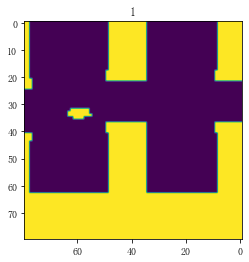

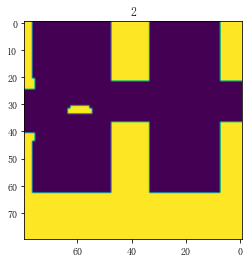

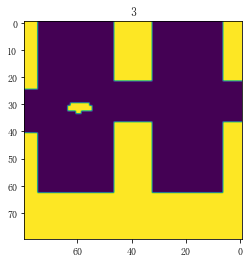

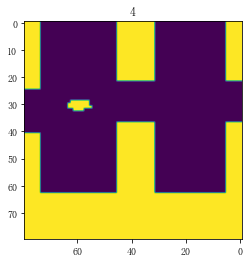

步数 241001 Q值 [12.309313 11.488249]===> 步数 241001 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 158 / 最高得分 1835
步数 241002 Q值 [12.267805 12.204356]===> 步数 241002 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 158 / 最高得分 1835
步数 241003 Q值 [12.1935835 12.549737 ]===> 步数 241003 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 158 / 最高得分 1835
步数 241004 Q值 [12.408901 11.626638]===> 步数 241004 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 158 / 最高得分 1835
步数 241005 Q值 [12.454749 11.127495]===> 步数 241005 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 158 / 最高得分 1835
步数 241006 Q值 [12.384238 10.89931 ]===> 步数 241006 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 158 / 最高得分 1835
步数 241007 Q值 [12.465731 10.685915]===> 步数 241007 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 158 / 最高得分 1835
步数 241008 Q值 [12.508413  9.257646]===> 步数 241008 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 158 / 最高得分 1835
步数 241009 Q值 [12.563266   7.9380326]===> 步数 241009 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 158 / 最高得分 1835
步数 241010 Q值 [12.604643  7.381024]===> 步数 241010 / 本

步数 241082 Q值 [12.450736 10.907325]===> 步数 241082 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 160 / 最高得分 1835
步数 241083 Q值 [12.40351  10.203693]===> 步数 241083 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 160 / 最高得分 1835
步数 241084 Q值 [12.489684  8.895961]===> 步数 241084 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 160 / 最高得分 1835
步数 241085 Q值 [12.533537  8.830459]===> 步数 241085 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 160 / 最高得分 1835
步数 241086 Q值 [12.522821  9.613776]===> 步数 241086 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 160 / 最高得分 1835
步数 241087 Q值 [12.489735  9.71292 ]===> 步数 241087 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 160 / 最高得分 1835
步数 241088 Q值 [12.497595  9.724561]===> 步数 241088 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 160 / 最高得分 1835
步数 241089 Q值 [12.557494 10.115027]===> 步数 241089 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 160 / 最高得分 1835
步数 241090 Q值 [12.581952 10.813199]===> 步数 241090 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 160 / 最高得分 1835
步数 241091 Q值 [12.572891 11.315651]===> 步数 241091 / 本次行为

步数 241162 Q值 [12.593813   6.9387465]===> 步数 241162 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 162 / 最高得分 1835
步数 241163 Q值 [12.738132   6.9046264]===> 步数 241163 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 162 / 最高得分 1835
步数 241164 Q值 [12.70229    6.6632185]===> 步数 241164 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 162 / 最高得分 1835
步数 241165 Q值 [12.691441  6.674514]===> 步数 241165 / 本次行为 0 不跳 / 本次奖励 1 / Running / 当前分数 163 / 最高得分 1835
步数 241166 Q值 [11.922641  5.802529]===> 步数 241166 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 163 / 最高得分 1835
步数 241167 Q值 [11.97989   7.649528]===> 步数 241167 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 163 / 最高得分 1835
步数 241168 Q值 [12.05117   9.100553]===> 步数 241168 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 163 / 最高得分 1835
步数 241169 Q值 [12.002648 10.077969]===> 步数 241169 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 163 / 最高得分 1835
步数 241170 Q值 [12.049445 10.837403]===> 步数 241170 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 163 / 最高得分 1835
步数 241171 Q值 [12.062009 11.422652]===> 步数 241171 / 

步数 241244 Q值 [11.890677  11.1184635]===> 步数 241244 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 165 / 最高得分 1835
步数 241245 Q值 [11.848217 11.647196]===> 步数 241245 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 165 / 最高得分 1835
步数 241246 Q值 [11.520711 12.015236]===> 步数 241246 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 165 / 最高得分 1835
步数 241247 Q值 [11.996159 11.594613]===> 步数 241247 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 165 / 最高得分 1835
步数 241248 Q值 [12.027673 11.620714]===> 步数 241248 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 165 / 最高得分 1835
步数 241249 Q值 [11.997471 11.567784]===> 步数 241249 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 165 / 最高得分 1835
步数 241250 Q值 [11.969176  9.906626]===> 步数 241250 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 165 / 最高得分 1835
步数 241251 Q值 [11.978863  8.340136]===> 步数 241251 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 165 / 最高得分 1835
步数 241252 Q值 [12.00771    6.4057627]===> 步数 241252 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 165 / 最高得分 1835
步数 241253 Q值 [12.021299   4.9793925]===> 步数 241253 /

步数 241327 Q值 [12.243619   3.5977027]===> 步数 241327 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 167 / 最高得分 1835
步数 241328 Q值 [12.145413   3.1025794]===> 步数 241328 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 167 / 最高得分 1835
步数 241329 Q值 [12.193065   2.6109495]===> 步数 241329 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 167 / 最高得分 1835
步数 241330 Q值 [12.202873   2.2240188]===> 步数 241330 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 167 / 最高得分 1835
步数 241331 Q值 [12.209517   1.6365728]===> 步数 241331 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 167 / 最高得分 1835
步数 241332 Q值 [12.305138   3.7057695]===> 步数 241332 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 167 / 最高得分 1835
步数 241333 Q值 [12.254923   3.9004595]===> 步数 241333 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 167 / 最高得分 1835
步数 241334 Q值 [12.192501  6.570612]===> 步数 241334 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 167 / 最高得分 1835
步数 241335 Q值 [12.278931   9.6343975]===> 步数 241335 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 167 / 最高得分 1835
步数 241336 Q值 [12.358327 11.080632]===> 

步数 241408 Q值 [12.192621   2.9841871]===> 步数 241408 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 169 / 最高得分 1835
步数 241409 Q值 [12.178365  4.56962 ]===> 步数 241409 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 169 / 最高得分 1835
步数 241410 Q值 [12.139853  5.493256]===> 步数 241410 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 169 / 最高得分 1835
步数 241411 Q值 [12.255085  7.315741]===> 步数 241411 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 169 / 最高得分 1835
步数 241412 Q值 [12.297819  8.934523]===> 步数 241412 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 169 / 最高得分 1835
步数 241413 Q值 [12.378054 11.044293]===> 步数 241413 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 169 / 最高得分 1835
步数 241414 Q值 [12.371017 11.927517]===> 步数 241414 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 169 / 最高得分 1835
步数 241415 Q值 [11.252671 12.346518]===> 步数 241415 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 169 / 最高得分 1835
步数 241416 Q值 [12.566274 11.004141]===> 步数 241416 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 169 / 最高得分 1835
步数 241417 Q值 [12.5910845  9.581661 ]===> 步数 241417 / 本

步数 241491 Q值 [12.644197   7.8503494]===> 步数 241491 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 171 / 最高得分 1835
步数 241492 Q值 [12.724314  8.044845]===> 步数 241492 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 171 / 最高得分 1835
步数 241493 Q值 [12.601315   6.6990314]===> 步数 241493 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 171 / 最高得分 1835
步数 241494 Q值 [12.666209  5.997417]===> 步数 241494 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 171 / 最高得分 1835
步数 241495 Q值 [12.66995    6.3528786]===> 步数 241495 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 171 / 最高得分 1835
步数 241496 Q值 [12.588034  6.59277 ]===> 步数 241496 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 171 / 最高得分 1835
步数 241497 Q值 [12.563198   5.8552647]===> 步数 241497 / 本次行为 0 不跳 / 本次奖励 1 / Running / 当前分数 172 / 最高得分 1835
步数 241498 Q值 [11.732634  5.044832]===> 步数 241498 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 172 / 最高得分 1835
步数 241499 Q值 [11.790359  6.55744 ]===> 步数 241499 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 172 / 最高得分 1835
步数 241500 Q值 [11.818211  8.066332]===> 步数 241500 

步数 241573 Q值 [11.750713 11.147264]===> 步数 241573 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 174 / 最高得分 1835
步数 241574 Q值 [11.482562 12.00718 ]===> 步数 241574 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 174 / 最高得分 1835
步数 241575 Q值 [12.001868 11.378838]===> 步数 241575 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 174 / 最高得分 1835
步数 241576 Q值 [11.916777 10.956131]===> 步数 241576 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 174 / 最高得分 1835
步数 241577 Q值 [11.964548 10.795152]===> 步数 241577 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 174 / 最高得分 1835
步数 241578 Q值 [12.006396 10.940579]===> 步数 241578 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 174 / 最高得分 1835
步数 241579 Q值 [11.933393 10.686743]===> 步数 241579 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 174 / 最高得分 1835
步数 241580 Q值 [11.9165   10.407907]===> 步数 241580 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 174 / 最高得分 1835
步数 241581 Q值 [11.913367  9.647983]===> 步数 241581 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 174 / 最高得分 1835
步数 241582 Q值 [12.038446  8.539996]===> 步数 241582 / 本次行为 

步数 241656 Q值 [11.825743 11.529532]===> 步数 241656 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 176 / 最高得分 1835
步数 241657 Q值 [11.700384 11.799114]===> 步数 241657 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 176 / 最高得分 1835
步数 241658 Q值 [11.885934 11.278996]===> 步数 241658 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 176 / 最高得分 1835
步数 241659 Q值 [11.919512 11.255818]===> 步数 241659 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 176 / 最高得分 1835
步数 241660 Q值 [11.910875 11.25955 ]===> 步数 241660 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 176 / 最高得分 1835
步数 241661 Q值 [11.981714 11.825808]===> 步数 241661 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 176 / 最高得分 1835
步数 241662 Q值 [12.011077 11.836022]===> 步数 241662 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 176 / 最高得分 1835
步数 241663 Q值 [12.076871 11.832685]===> 步数 241663 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 176 / 最高得分 1835
步数 241664 Q值 [12.160602 11.793543]===> 步数 241664 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 176 / 最高得分 1835
步数 241665 Q值 [12.217234 11.972987]===> 步数 241665 / 本次行为 

步数 241739 Q值 [12.202845   2.6876652]===> 步数 241739 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 178 / 最高得分 1835
步数 241740 Q值 [12.117061  4.573429]===> 步数 241740 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 178 / 最高得分 1835
步数 241741 Q值 [12.236704  5.358818]===> 步数 241741 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 178 / 最高得分 1835
步数 241742 Q值 [12.1730175  8.935713 ]===> 步数 241742 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 178 / 最高得分 1835
步数 241743 Q值 [12.264535 10.896928]===> 步数 241743 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 178 / 最高得分 1835
步数 241744 Q值 [12.2072735 11.973623 ]===> 步数 241744 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 178 / 最高得分 1835
步数 241745 Q值 [10.118156 12.328242]===> 步数 241745 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 178 / 最高得分 1835
步数 241746 Q值 [12.289184 11.00956 ]===> 步数 241746 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 178 / 最高得分 1835
步数 241747 Q值 [12.404291  10.2317095]===> 步数 241747 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 178 / 最高得分 1835
步数 241748 Q值 [12.295141 10.356778]===> 步数 241748

步数 241822 Q值 [11.366412 12.081651]===> 步数 241822 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 180 / 最高得分 1835
步数 241823 Q值 [12.403738 11.374026]===> 步数 241823 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 180 / 最高得分 1835
步数 241824 Q值 [12.463697 10.578325]===> 步数 241824 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 180 / 最高得分 1835
步数 241825 Q值 [12.413337  7.533505]===> 步数 241825 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 180 / 最高得分 1835
步数 241826 Q值 [12.444071  5.304098]===> 步数 241826 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 180 / 最高得分 1835
步数 241827 Q值 [12.457417   3.5581257]===> 步数 241827 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 180 / 最高得分 1835
步数 241828 Q值 [12.590406   3.7689457]===> 步数 241828 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 180 / 最高得分 1835
步数 241829 Q值 [12.663552   2.4022787]===> 步数 241829 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 180 / 最高得分 1835
步数 241830 Q值 [12.623099  2.215217]===> 步数 241830 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 180 / 最高得分 1835
步数 241831 Q值 [12.629804  1.781671]===> 步数 241831 /

步数 241903 Q值 [12.622755  8.132588]===> 步数 241903 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 182 / 最高得分 1835
步数 241904 Q值 [12.652036  6.946198]===> 步数 241904 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 182 / 最高得分 1835
步数 241905 Q值 [12.640254  5.912269]===> 步数 241905 / 本次行为 0 不跳 / 本次奖励 1 / Running / 当前分数 183 / 最高得分 1835
步数 241906 Q值 [11.746683   3.0579228]===> 步数 241906 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 183 / 最高得分 1835
步数 241907 Q值 [11.725394   2.6974194]===> 步数 241907 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 183 / 最高得分 1835
步数 241908 Q值 [11.809866  3.475899]===> 步数 241908 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 183 / 最高得分 1835
步数 241909 Q值 [11.896327  4.752533]===> 步数 241909 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 183 / 最高得分 1835
步数 241910 Q值 [11.939752   6.5298185]===> 步数 241910 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 183 / 最高得分 1835
步数 241911 Q值 [11.935034  8.409078]===> 步数 241911 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 183 / 最高得分 1835
步数 241912 Q值 [11.897723  9.556883]===> 步数 241912 / 

步数 241983 Q值 [11.802788  8.026415]===> 步数 241983 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 185 / 最高得分 1835
步数 241984 Q值 [11.935762  8.241609]===> 步数 241984 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 185 / 最高得分 1835
步数 241985 Q值 [11.880437  7.855975]===> 步数 241985 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 185 / 最高得分 1835
步数 241986 Q值 [11.883582  8.496946]===> 步数 241986 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 185 / 最高得分 1835
步数 241987 Q值 [11.935871  9.219122]===> 步数 241987 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 185 / 最高得分 1835
步数 241988 Q值 [11.971242 10.049854]===> 步数 241988 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 185 / 最高得分 1835
步数 241989 Q值 [12.019568 10.428986]===> 步数 241989 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 185 / 最高得分 1835
步数 241990 Q值 [12.129738 11.137062]===> 步数 241990 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 185 / 最高得分 1835
步数 241991 Q值 [12.193337 11.273296]===> 步数 241991 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 185 / 最高得分 1835
步数 241992 Q值 [12.141008 11.285953]===> 步数 241992 / 本次行为

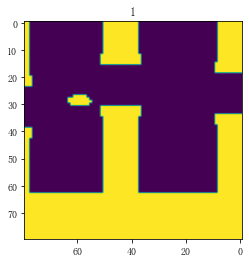

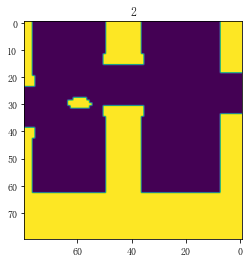

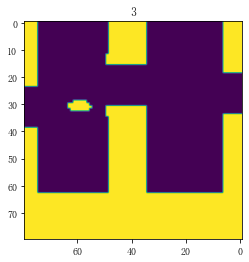

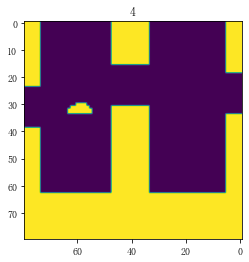

步数 242001 Q值 [12.284916 11.872122]===> 步数 242001 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 185 / 最高得分 1835
步数 242002 Q值 [12.145644 11.853573]===> 步数 242002 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 185 / 最高得分 1835
步数 242003 Q值 [12.240245 11.521869]===> 步数 242003 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 185 / 最高得分 1835
步数 242004 Q值 [12.462082 12.209411]===> 步数 242004 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 185 / 最高得分 1835
步数 242005 Q值 [12.439651 11.701679]===> 步数 242005 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 185 / 最高得分 1835
步数 242006 Q值 [12.476961 11.668957]===> 步数 242006 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 185 / 最高得分 1835
步数 242007 Q值 [12.492524 11.283507]===> 步数 242007 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 185 / 最高得分 1835
步数 242008 Q值 [12.518692 11.563549]===> 步数 242008 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 185 / 最高得分 1835
步数 242009 Q值 [12.533856 12.088461]===> 步数 242009 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 185 / 最高得分 1835
步数 242010 Q值 [12.456157 12.250835]===> 步数 242010 / 本次行为

步数 242081 Q值 [12.502935 10.780493]===> 步数 242081 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 187 / 最高得分 1835
步数 242082 Q值 [12.523204 10.118679]===> 步数 242082 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 187 / 最高得分 1835
步数 242083 Q值 [12.573043  9.785535]===> 步数 242083 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 187 / 最高得分 1835
步数 242084 Q值 [12.579227 10.487495]===> 步数 242084 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 187 / 最高得分 1835
步数 242085 Q值 [12.562311 10.877102]===> 步数 242085 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 187 / 最高得分 1835
步数 242086 Q值 [12.6384945 11.142833 ]===> 步数 242086 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 187 / 最高得分 1835
步数 242087 Q值 [12.70911  11.274891]===> 步数 242087 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 187 / 最高得分 1835
步数 242088 Q值 [12.617369 11.78506 ]===> 步数 242088 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 187 / 最高得分 1835
步数 242089 Q值 [12.463935 12.280296]===> 步数 242089 / 本次行为 0 不跳 / 本次奖励 1 / Running / 当前分数 188 / 最高得分 1835
步数 242090 Q值 [ 6.0453005 11.558582 ]===> 步数 242090 / 本次

步数 242159 Q值 [12.610919  10.6003895]===> 步数 242159 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 189 / 最高得分 1835
步数 242160 Q值 [12.617419 11.505315]===> 步数 242160 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 189 / 最高得分 1835
步数 242161 Q值 [12.672768 11.886619]===> 步数 242161 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 189 / 最高得分 1835
步数 242162 Q值 [12.476578 12.417022]===> 步数 242162 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 189 / 最高得分 1835
步数 242163 Q值 [12.440764 12.193327]===> 步数 242163 / 本次行为 0 不跳 / 本次奖励 1 / Running / 当前分数 190 / 最高得分 1835
步数 242164 Q值 [ 7.274146 11.630485]===> 步数 242164 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 190 / 最高得分 1835
步数 242165 Q值 [11.729315 11.008212]===> 步数 242165 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 190 / 最高得分 1835
步数 242166 Q值 [11.796743 10.501861]===> 步数 242166 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 190 / 最高得分 1835
步数 242167 Q值 [11.854862 11.097664]===> 步数 242167 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 190 / 最高得分 1835
步数 242168 Q值 [11.868924 10.795755]===> 步数 242168 / 本次行为 

步数 242241 Q值 [12.026704 11.348176]===> 步数 242241 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 192 / 最高得分 1835
步数 242242 Q值 [12.012705 11.681683]===> 步数 242242 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 192 / 最高得分 1835
步数 242243 Q值 [11.722692 12.140599]===> 步数 242243 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 192 / 最高得分 1835
步数 242244 Q值 [12.102934 11.669436]===> 步数 242244 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 192 / 最高得分 1835
步数 242245 Q值 [12.093945 11.516414]===> 步数 242245 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 192 / 最高得分 1835
步数 242246 Q值 [12.0437765 12.158768 ]===> 步数 242246 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 192 / 最高得分 1835
步数 242247 Q值 [12.009766 11.192484]===> 步数 242247 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 192 / 最高得分 1835
步数 242248 Q值 [12.006034 10.563511]===> 步数 242248 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 192 / 最高得分 1835
步数 242249 Q值 [11.987908  9.974451]===> 步数 242249 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 192 / 最高得分 1835
步数 242250 Q值 [12.0020685  9.331424 ]===> 步数 242250 / 本次

步数 242322 Q值 [11.931924 10.655426]===> 步数 242322 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 194 / 最高得分 1835
步数 242323 Q值 [11.955305 10.342686]===> 步数 242323 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 194 / 最高得分 1835
步数 242324 Q值 [11.935937  8.312857]===> 步数 242324 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 194 / 最高得分 1835
步数 242325 Q值 [11.995851  6.870133]===> 步数 242325 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 194 / 最高得分 1835
步数 242326 Q值 [11.998816   5.7166224]===> 步数 242326 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 194 / 最高得分 1835
步数 242327 Q值 [12.121525   4.1949854]===> 步数 242327 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 194 / 最高得分 1835
步数 242328 Q值 [12.110668   3.1841812]===> 步数 242328 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 194 / 最高得分 1835
步数 242329 Q值 [12.080236  2.433091]===> 步数 242329 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 194 / 最高得分 1835
步数 242330 Q值 [12.085405   2.8893535]===> 步数 242330 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 194 / 最高得分 1835
步数 242331 Q值 [12.04316   2.977509]===> 步数 24233

步数 242402 Q值 [11.875254   3.3095894]===> 步数 242402 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 196 / 最高得分 1835
步数 242403 Q值 [11.8883915  2.8393826]===> 步数 242403 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 196 / 最高得分 1835
步数 242404 Q值 [11.930814   3.6541572]===> 步数 242404 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 196 / 最高得分 1835
步数 242405 Q值 [12.071338   2.1203306]===> 步数 242405 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 196 / 最高得分 1835
步数 242406 Q值 [11.971668   1.7887751]===> 步数 242406 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 196 / 最高得分 1835
步数 242407 Q值 [12.000971   3.1705818]===> 步数 242407 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 196 / 最高得分 1835
步数 242408 Q值 [12.057553   5.6889668]===> 步数 242408 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 196 / 最高得分 1835
步数 242409 Q值 [12.092272  9.044005]===> 步数 242409 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 196 / 最高得分 1835
步数 242410 Q值 [12.063921 10.999952]===> 步数 242410 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 196 / 最高得分 1835
步数 242411 Q值 [ 9.816558 12.324249]===> 步数

步数 242482 Q值 [12.201817   -0.10129189]===> 步数 242482 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 198 / 最高得分 1835
步数 242483 Q值 [12.259176   -0.16127473]===> 步数 242483 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 198 / 最高得分 1835
步数 242484 Q值 [12.309022  -0.3234447]===> 步数 242484 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 198 / 最高得分 1835
步数 242485 Q值 [12.3214855  1.558464 ]===> 步数 242485 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 198 / 最高得分 1835
步数 242486 Q值 [12.261801   3.8724794]===> 步数 242486 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 198 / 最高得分 1835
步数 242487 Q值 [12.428059  6.238091]===> 步数 242487 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 198 / 最高得分 1835
步数 242488 Q值 [12.224224  9.727202]===> 步数 242488 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 198 / 最高得分 1835
步数 242489 Q值 [12.385598 11.682113]===> 步数 242489 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 198 / 最高得分 1835
步数 242490 Q值 [ 9.423228 12.631719]===> 步数 242490 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 198 / 最高得分 1835
步数 242491 Q值 [12.630568 11.565988]===> 步数 

步数 242564 Q值 [12.423155  9.481171]===> 步数 242564 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 200 / 最高得分 1835
步数 242565 Q值 [12.495166  8.551622]===> 步数 242565 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 200 / 最高得分 1835
步数 242566 Q值 [12.53012   7.978709]===> 步数 242566 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 200 / 最高得分 1835
步数 242567 Q值 [12.590535   7.6695614]===> 步数 242567 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 200 / 最高得分 1835
步数 242568 Q值 [12.617243   7.3926773]===> 步数 242568 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 200 / 最高得分 1835
步数 242569 Q值 [12.592219   8.8081255]===> 步数 242569 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 200 / 最高得分 1835
步数 242570 Q值 [12.642958 10.577298]===> 步数 242570 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 200 / 最高得分 1835
步数 242571 Q值 [12.6471195 11.549864 ]===> 步数 242571 / 本次行为 0 不跳 / 本次奖励 1 / Running / 当前分数 201 / 最高得分 1835
步数 242572 Q值 [11.8809395 11.0813675]===> 步数 242572 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 201 / 最高得分 1835
步数 242573 Q值 [11.641034 11.782859]===> 步数 24257

步数 242647 Q值 [11.94717   5.979125]===> 步数 242647 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 203 / 最高得分 1835
步数 242648 Q值 [12.070704   4.3049088]===> 步数 242648 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 203 / 最高得分 1835
步数 242649 Q值 [11.991404  4.547575]===> 步数 242649 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 203 / 最高得分 1835
步数 242650 Q值 [12.02389    5.0858746]===> 步数 242650 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 203 / 最高得分 1835
步数 242651 Q值 [12.011789  5.447313]===> 步数 242651 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 203 / 最高得分 1835
步数 242652 Q值 [11.922438  6.105764]===> 步数 242652 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 203 / 最高得分 1835
步数 242653 Q值 [11.937729  5.768593]===> 步数 242653 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 203 / 最高得分 1835
步数 242654 Q值 [12.033726   4.4629927]===> 步数 242654 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 203 / 最高得分 1835
步数 242655 Q值 [11.98347    4.7194858]===> 步数 242655 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 203 / 最高得分 1835
步数 242656 Q值 [12.0314455  3.175197 ]===> 步数 242

步数 242727 Q值 [11.938758  10.1466675]===> 步数 242727 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 205 / 最高得分 1835
步数 242728 Q值 [11.911495  9.867962]===> 步数 242728 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 205 / 最高得分 1835
步数 242729 Q值 [11.911026  9.643202]===> 步数 242729 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 205 / 最高得分 1835
步数 242730 Q值 [11.980888  8.452671]===> 步数 242730 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 205 / 最高得分 1835
步数 242731 Q值 [12.054648  7.144117]===> 步数 242731 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 205 / 最高得分 1835
步数 242732 Q值 [12.021768  5.986735]===> 步数 242732 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 205 / 最高得分 1835
步数 242733 Q值 [12.015716   6.1649218]===> 步数 242733 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 205 / 最高得分 1835
步数 242734 Q值 [12.029428  5.634703]===> 步数 242734 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 205 / 最高得分 1835
步数 242735 Q值 [12.0374565  6.3607235]===> 步数 242735 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 205 / 最高得分 1835
步数 242736 Q值 [12.110815  6.911312]===> 步数 242736 

步数 242810 Q值 [12.200078   1.5518516]===> 步数 242810 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 207 / 最高得分 1835
步数 242811 Q值 [12.2554865  1.7528301]===> 步数 242811 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 207 / 最高得分 1835
步数 242812 Q值 [12.262748   2.8520775]===> 步数 242812 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 207 / 最高得分 1835
步数 242813 Q值 [12.210228  3.605178]===> 步数 242813 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 207 / 最高得分 1835
步数 242814 Q值 [12.167395   6.4741635]===> 步数 242814 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 207 / 最高得分 1835
步数 242815 Q值 [12.311869 10.465235]===> 步数 242815 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 207 / 最高得分 1835
步数 242816 Q值 [12.289802 11.00345 ]===> 步数 242816 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 207 / 最高得分 1835
步数 242817 Q值 [12.001629 12.401032]===> 步数 242817 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 207 / 最高得分 1835
步数 242818 Q值 [12.206928 11.691505]===> 步数 242818 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 207 / 最高得分 1835
步数 242819 Q值 [12.345024 10.646777]===> 步数 242819

步数 242892 Q值 [12.592287 11.679   ]===> 步数 242892 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 209 / 最高得分 1835
步数 242893 Q值 [12.541194 10.919994]===> 步数 242893 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 209 / 最高得分 1835
步数 242894 Q值 [12.4346075 10.096337 ]===> 步数 242894 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 209 / 最高得分 1835
步数 242895 Q值 [12.47253   7.784911]===> 步数 242895 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 209 / 最高得分 1835
步数 242896 Q值 [12.545474   5.8637004]===> 步数 242896 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 209 / 最高得分 1835
步数 242897 Q值 [12.543436   3.9408937]===> 步数 242897 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 209 / 最高得分 1835
步数 242898 Q值 [12.584559  3.279336]===> 步数 242898 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 209 / 最高得分 1835
步数 242899 Q值 [12.530712  2.921267]===> 步数 242899 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 209 / 最高得分 1835
步数 242900 Q值 [12.473961   3.0978272]===> 步数 242900 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 209 / 最高得分 1835
步数 242901 Q值 [12.505796   4.0986233]===> 步数 242

步数 242975 Q值 [12.597243  4.929484]===> 步数 242975 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 211 / 最高得分 1835
步数 242976 Q值 [12.653979  5.770628]===> 步数 242976 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 211 / 最高得分 1835
步数 242977 Q值 [12.615781   5.6582365]===> 步数 242977 / 本次行为 0 不跳 / 本次奖励 1 / Running / 当前分数 212 / 最高得分 1835
步数 242978 Q值 [11.691864  4.480062]===> 步数 242978 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 212 / 最高得分 1835
步数 242979 Q值 [11.707311   6.5504074]===> 步数 242979 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 212 / 最高得分 1835
步数 242980 Q值 [11.687058  9.090181]===> 步数 242980 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 212 / 最高得分 1835
步数 242981 Q值 [11.750824  9.986158]===> 步数 242981 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 212 / 最高得分 1835
步数 242982 Q值 [11.754609 11.203215]===> 步数 242982 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 212 / 最高得分 1835
步数 242983 Q值 [11.686269 11.222194]===> 步数 242983 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 212 / 最高得分 1835
步数 242984 Q值 [11.58968  11.462271]===> 步数 242984 / 本次

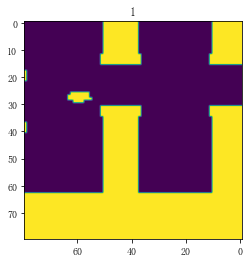

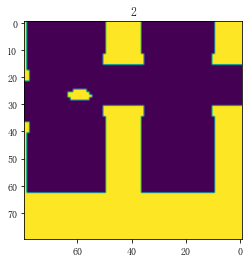

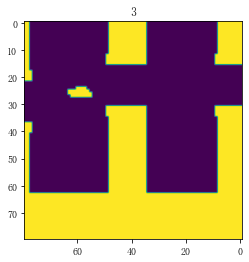

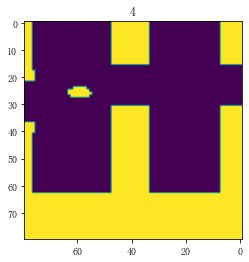

步数 243001 Q值 [12.094566 10.938174]===> 步数 243001 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 212 / 最高得分 1835
步数 243002 Q值 [11.977348 12.030217]===> 步数 243002 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 212 / 最高得分 1835
步数 243003 Q值 [12.151378 11.020704]===> 步数 243003 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 212 / 最高得分 1835
步数 243004 Q值 [12.24426  10.445688]===> 步数 243004 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 212 / 最高得分 1835
步数 243005 Q值 [12.3810215  9.851326 ]===> 步数 243005 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 212 / 最高得分 1835
步数 243006 Q值 [12.327953  6.909009]===> 步数 243006 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 212 / 最高得分 1835
步数 243007 Q值 [12.431607   5.3495083]===> 步数 243007 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 212 / 最高得分 1835
步数 243008 Q值 [12.530399   4.4005637]===> 步数 243008 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 212 / 最高得分 1835
步数 243009 Q值 [12.451531   3.2404664]===> 步数 243009 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 212 / 最高得分 1835
步数 243010 Q值 [12.520559   1.9456882]===> 步数 2430

步数 243083 Q值 [12.60233   9.551612]===> 步数 243083 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 214 / 最高得分 1835
步数 243084 Q值 [12.644684   6.7201033]===> 步数 243084 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 214 / 最高得分 1835
步数 243085 Q值 [12.575018  4.256823]===> 步数 243085 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 214 / 最高得分 1835
步数 243086 Q值 [12.626642   4.1701994]===> 步数 243086 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 214 / 最高得分 1835
步数 243087 Q值 [12.74598    4.2588873]===> 步数 243087 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 214 / 最高得分 1835
步数 243088 Q值 [12.825781   4.3556094]===> 步数 243088 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 214 / 最高得分 1835
步数 243089 Q值 [12.733667   2.6506045]===> 步数 243089 / 本次行为 0 不跳 / 本次奖励 1 / Running / 当前分数 215 / 最高得分 1835
步数 243090 Q值 [11.868119   1.6137406]===> 步数 243090 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 215 / 最高得分 1835
步数 243091 Q值 [11.89694    2.3783312]===> 步数 243091 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 215 / 最高得分 1835
步数 243092 Q值 [11.954602  3.925976]===> 步数 2

步数 243164 Q值 [11.993212   5.2408147]===> 步数 243164 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 217 / 最高得分 1835
步数 243165 Q值 [12.000986   6.4595914]===> 步数 243165 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 217 / 最高得分 1835
步数 243166 Q值 [12.090306  5.780516]===> 步数 243166 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 217 / 最高得分 1835
步数 243167 Q值 [12.004295  6.044851]===> 步数 243167 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 217 / 最高得分 1835
步数 243168 Q值 [11.996246   7.4313426]===> 步数 243168 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 217 / 最高得分 1835
步数 243169 Q值 [12.00933   8.625965]===> 步数 243169 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 217 / 最高得分 1835
步数 243170 Q值 [12.014617  8.549547]===> 步数 243170 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 217 / 最高得分 1835
步数 243171 Q值 [12.015408  9.89899 ]===> 步数 243171 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 217 / 最高得分 1835
步数 243172 Q值 [12.091211 10.889662]===> 步数 243172 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 217 / 最高得分 1835
步数 243173 Q值 [12.007378 10.892349]===> 步数 243173 

步数 243247 Q值 [11.90642  10.180494]===> 步数 243247 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 219 / 最高得分 1835
步数 243248 Q值 [11.91868   9.938343]===> 步数 243248 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 219 / 最高得分 1835
步数 243249 Q值 [11.947762  9.18797 ]===> 步数 243249 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 219 / 最高得分 1835
步数 243250 Q值 [12.026162  8.570306]===> 步数 243250 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 219 / 最高得分 1835
步数 243251 Q值 [12.044863  9.967632]===> 步数 243251 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 219 / 最高得分 1835
步数 243252 Q值 [12.111909 10.655586]===> 步数 243252 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 219 / 最高得分 1835
步数 243253 Q值 [12.154081 11.161136]===> 步数 243253 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 219 / 最高得分 1835
步数 243254 Q值 [12.103123 11.678101]===> 步数 243254 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 219 / 最高得分 1835
步数 243255 Q值 [12.110612 11.91517 ]===> 步数 243255 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 219 / 最高得分 1835
步数 243256 Q值 [11.678442 12.180535]===> 步数 243256 / 本次行为

步数 243329 Q值 [12.241581 11.231003]===> 步数 243329 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 221 / 最高得分 1835
步数 243330 Q值 [12.298096  11.9253025]===> 步数 243330 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 221 / 最高得分 1835
步数 243331 Q值 [12.097218 12.562349]===> 步数 243331 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 221 / 最高得分 1835
步数 243332 Q值 [12.237677 12.199271]===> 步数 243332 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 221 / 最高得分 1835
步数 243333 Q值 [12.411163 11.848504]===> 步数 243333 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 221 / 最高得分 1835
步数 243334 Q值 [12.274305 11.486669]===> 步数 243334 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 221 / 最高得分 1835
步数 243335 Q值 [12.329591 11.664904]===> 步数 243335 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 221 / 最高得分 1835
步数 243336 Q值 [12.3397875 11.150811 ]===> 步数 243336 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 221 / 最高得分 1835
步数 243337 Q值 [12.41666  10.590191]===> 步数 243337 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 221 / 最高得分 1835
步数 243338 Q值 [12.421276 10.267877]===> 步数 243338 / 本

步数 243408 Q值 [ 9.956276 12.348268]===> 步数 243408 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 223 / 最高得分 1835
步数 243409 Q值 [12.25398  12.179623]===> 步数 243409 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 223 / 最高得分 1835
步数 243410 Q值 [12.324818 11.277424]===> 步数 243410 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 223 / 最高得分 1835
步数 243411 Q值 [12.447459 11.232607]===> 步数 243411 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 223 / 最高得分 1835
步数 243412 Q值 [12.54203  11.521262]===> 步数 243412 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 223 / 最高得分 1835
步数 243413 Q值 [12.601532 11.423713]===> 步数 243413 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 223 / 最高得分 1835
步数 243414 Q值 [12.5263815 11.251072 ]===> 步数 243414 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 223 / 最高得分 1835
步数 243415 Q值 [12.51703  10.939142]===> 步数 243415 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 223 / 最高得分 1835
步数 243416 Q值 [12.5732565 10.865846 ]===> 步数 243416 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 223 / 最高得分 1835
步数 243417 Q值 [12.629127 11.078239]===> 步数 243417 / 本

步数 243488 Q值 [12.63021   5.524703]===> 步数 243488 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 225 / 最高得分 1835
步数 243489 Q值 [12.627626   4.6012516]===> 步数 243489 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 225 / 最高得分 1835
步数 243490 Q值 [12.657321  5.464692]===> 步数 243490 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 225 / 最高得分 1835
步数 243491 Q值 [12.62187   7.146572]===> 步数 243491 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 225 / 最高得分 1835
步数 243492 Q值 [12.553313  8.121596]===> 步数 243492 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 225 / 最高得分 1835
步数 243493 Q值 [12.586024  9.854359]===> 步数 243493 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 225 / 最高得分 1835
步数 243494 Q值 [12.530536 11.704083]===> 步数 243494 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 225 / 最高得分 1835
步数 243495 Q值 [12.565415 12.362818]===> 步数 243495 / 本次行为 0 不跳 / 本次奖励 1 / Running / 当前分数 226 / 最高得分 1835
步数 243496 Q值 [10.363101 11.781357]===> 步数 243496 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 226 / 最高得分 1835
步数 243497 Q值 [11.808094 11.263141]===> 步数 243497 / 本次行为 

步数 243569 Q值 [12.664862 11.54731 ]===> 步数 243569 / 本次行为 0 不跳 / 本次奖励 1 / Running / 当前分数 228 / 最高得分 1835
步数 243570 Q值 [11.684037 10.93888 ]===> 步数 243570 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 228 / 最高得分 1835
步数 243571 Q值 [11.208613 12.006248]===> 步数 243571 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 228 / 最高得分 1835
步数 243572 Q值 [11.814375 11.4389  ]===> 步数 243572 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 228 / 最高得分 1835
步数 243573 Q值 [11.991418 10.901632]===> 步数 243573 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 228 / 最高得分 1835
步数 243574 Q值 [11.904216 10.770247]===> 步数 243574 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 228 / 最高得分 1835
步数 243575 Q值 [11.97863  10.638826]===> 步数 243575 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 228 / 最高得分 1835
步数 243576 Q值 [12.0485325 10.827019 ]===> 步数 243576 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 228 / 最高得分 1835
步数 243577 Q值 [12.034533 10.803132]===> 步数 243577 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 228 / 最高得分 1835
步数 243578 Q值 [11.964134 10.614412]===> 步数 243578 / 本次行为 

步数 243648 Q值 [11.340158 12.124217]===> 步数 243648 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 230 / 最高得分 1835
步数 243649 Q值 [11.941717 11.205869]===> 步数 243649 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 230 / 最高得分 1835
步数 243650 Q值 [11.9887295 11.132265 ]===> 步数 243650 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 230 / 最高得分 1835
步数 243651 Q值 [11.9818945 11.74604  ]===> 步数 243651 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 230 / 最高得分 1835
步数 243652 Q值 [11.938983 11.882544]===> 步数 243652 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 230 / 最高得分 1835
步数 243653 Q值 [11.925949 10.959015]===> 步数 243653 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 230 / 最高得分 1835
步数 243654 Q值 [11.923434 10.303941]===> 步数 243654 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 230 / 最高得分 1835
步数 243655 Q值 [11.903147 10.163622]===> 步数 243655 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 230 / 最高得分 1835
步数 243656 Q值 [12.018392  9.32783 ]===> 步数 243656 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 230 / 最高得分 1835
步数 243657 Q值 [12.070348  8.23644 ]===> 步数 243657 / 本

步数 243728 Q值 [11.888664 10.949076]===> 步数 243728 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 232 / 最高得分 1835
步数 243729 Q值 [11.9246235 10.706897 ]===> 步数 243729 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 232 / 最高得分 1835
步数 243730 Q值 [12.024567  9.932029]===> 步数 243730 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 232 / 最高得分 1835
步数 243731 Q值 [11.996812  9.402906]===> 步数 243731 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 232 / 最高得分 1835
步数 243732 Q值 [12.08139    7.7210336]===> 步数 243732 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 232 / 最高得分 1835
步数 243733 Q值 [12.097606  6.509441]===> 步数 243733 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 232 / 最高得分 1835
步数 243734 Q值 [12.199232  5.079665]===> 步数 243734 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 232 / 最高得分 1835
步数 243735 Q值 [12.2350025  4.2055655]===> 步数 243735 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 232 / 最高得分 1835
步数 243736 Q值 [12.166402  4.509736]===> 步数 243736 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 232 / 最高得分 1835
步数 243737 Q值 [12.195411  5.593539]===> 步数 243737 

步数 243810 Q值 [12.107963   0.7963562]===> 步数 243810 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 234 / 最高得分 1835
步数 243811 Q值 [12.20046     0.10180695]===> 步数 243811 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 234 / 最高得分 1835
步数 243812 Q值 [12.12802     0.13492452]===> 步数 243812 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 234 / 最高得分 1835
步数 243813 Q值 [12.143928    0.36960384]===> 步数 243813 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 234 / 最高得分 1835
步数 243814 Q值 [12.155013  1.493757]===> 步数 243814 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 234 / 最高得分 1835
步数 243815 Q值 [12.203017   3.3734639]===> 步数 243815 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 234 / 最高得分 1835
步数 243816 Q值 [12.193813   5.2717724]===> 步数 243816 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 234 / 最高得分 1835
步数 243817 Q值 [12.141588   7.5211444]===> 步数 243817 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 234 / 最高得分 1835
步数 243818 Q值 [12.220244 10.625194]===> 步数 243818 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 234 / 最高得分 1835
步数 243819 Q值 [11.865324 11.84764 ]=

步数 243888 Q值 [12.370304 11.878169]===> 步数 243888 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 236 / 最高得分 1835
步数 243889 Q值 [12.39893  11.934308]===> 步数 243889 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 236 / 最高得分 1835
步数 243890 Q值 [12.352746 12.096217]===> 步数 243890 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 236 / 最高得分 1835
步数 243891 Q值 [12.41397  12.114948]===> 步数 243891 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 236 / 最高得分 1835
步数 243892 Q值 [12.292345 11.908474]===> 步数 243892 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 236 / 最高得分 1835
步数 243893 Q值 [12.39758  11.710123]===> 步数 243893 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 236 / 最高得分 1835
步数 243894 Q值 [12.486994 11.841856]===> 步数 243894 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 236 / 最高得分 1835
步数 243895 Q值 [12.510036 11.541992]===> 步数 243895 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 236 / 最高得分 1835
步数 243896 Q值 [12.559782 11.363779]===> 步数 243896 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 236 / 最高得分 1835
步数 243897 Q值 [12.63006  11.922816]===> 步数 243897 / 本次行为

步数 243971 Q值 [12.588501  6.210786]===> 步数 243971 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 238 / 最高得分 1835
步数 243972 Q值 [12.634461  5.738633]===> 步数 243972 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 238 / 最高得分 1835
步数 243973 Q值 [12.686818  6.29618 ]===> 步数 243973 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 238 / 最高得分 1835
步数 243974 Q值 [12.570503   7.1189055]===> 步数 243974 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 238 / 最高得分 1835
步数 243975 Q值 [12.609595  9.662912]===> 步数 243975 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 238 / 最高得分 1835
步数 243976 Q值 [12.621868 10.802773]===> 步数 243976 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 238 / 最高得分 1835
步数 243977 Q值 [12.587856 11.522945]===> 步数 243977 / 本次行为 0 不跳 / 本次奖励 1 / Running / 当前分数 239 / 最高得分 1835
步数 243978 Q值 [ 8.515459 11.782367]===> 步数 243978 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 239 / 最高得分 1835
步数 243979 Q值 [11.856006  10.3654785]===> 步数 243979 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 239 / 最高得分 1835
步数 243980 Q值 [11.77951  10.437836]===> 步数 243980 / 本次行

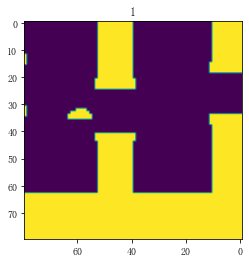

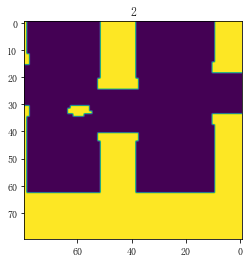

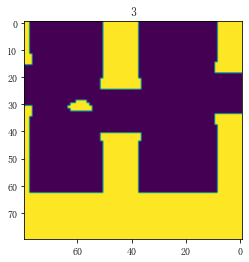

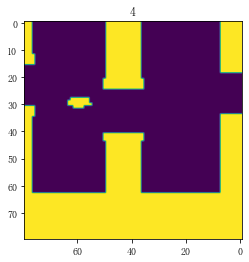

步数 244001 Q值 [12.340555  10.4448185]===> 步数 244001 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 239 / 最高得分 1835
步数 244002 Q值 [12.316463 11.735242]===> 步数 244002 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 239 / 最高得分 1835
步数 244003 Q值 [12.120402 12.211784]===> 步数 244003 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 239 / 最高得分 1835
步数 244004 Q值 [12.444058 11.287473]===> 步数 244004 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 239 / 最高得分 1835
步数 244005 Q值 [12.194042 10.597114]===> 步数 244005 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 239 / 最高得分 1835
步数 244006 Q值 [12.47017   8.387581]===> 步数 244006 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 239 / 最高得分 1835
步数 244007 Q值 [12.587254  7.154642]===> 步数 244007 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 239 / 最高得分 1835
步数 244008 Q值 [12.63697    6.3729277]===> 步数 244008 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 239 / 最高得分 1835
步数 244009 Q值 [12.5649185  4.552931 ]===> 步数 244009 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 239 / 最高得分 1835
步数 244010 Q值 [12.660664   3.3903818]===> 步数 244010

步数 244083 Q值 [12.553092   5.5827684]===> 步数 244083 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 241 / 最高得分 1835
步数 244084 Q值 [12.571813  5.511804]===> 步数 244084 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 241 / 最高得分 1835
步数 244085 Q值 [12.652951  6.15388 ]===> 步数 244085 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 241 / 最高得分 1835
步数 244086 Q值 [12.669103   7.9764757]===> 步数 244086 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 241 / 最高得分 1835
步数 244087 Q值 [12.690889  9.984927]===> 步数 244087 / 本次行为 0 不跳 / 本次奖励 1 / Running / 当前分数 242 / 最高得分 1835
步数 244088 Q值 [11.848634 10.220972]===> 步数 244088 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 242 / 最高得分 1835
步数 244089 Q值 [11.743827 11.042668]===> 步数 244089 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 242 / 最高得分 1835
步数 244090 Q值 [11.546285 11.855908]===> 步数 244090 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 242 / 最高得分 1835
步数 244091 Q值 [11.9545965 11.131731 ]===> 步数 244091 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 242 / 最高得分 1835
步数 244092 Q值 [11.9388685 10.717851 ]===> 步数 244092 /

步数 244165 Q值 [11.637052 11.625927]===> 步数 244165 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 244 / 最高得分 1835
步数 244166 Q值 [10.804541 12.103924]===> 步数 244166 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 244 / 最高得分 1835
步数 244167 Q值 [11.772803 11.68365 ]===> 步数 244167 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 244 / 最高得分 1835
步数 244168 Q值 [11.850981 11.327729]===> 步数 244168 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 244 / 最高得分 1835
步数 244169 Q值 [11.854263 11.363176]===> 步数 244169 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 244 / 最高得分 1835
步数 244170 Q值 [11.826261 11.184548]===> 步数 244170 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 244 / 最高得分 1835
步数 244171 Q值 [11.863549 10.885008]===> 步数 244171 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 244 / 最高得分 1835
步数 244172 Q值 [11.909422 10.612401]===> 步数 244172 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 244 / 最高得分 1835
步数 244173 Q值 [11.931143 10.412357]===> 步数 244173 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 244 / 最高得分 1835
步数 244174 Q值 [12.004105 10.522007]===> 步数 244174 / 本次行为 

步数 244247 Q值 [11.903132  8.882339]===> 步数 244247 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 246 / 最高得分 1835
步数 244248 Q值 [11.938044  6.465619]===> 步数 244248 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 246 / 最高得分 1835
步数 244249 Q值 [12.090174   5.7676916]===> 步数 244249 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 246 / 最高得分 1835
步数 244250 Q值 [12.094689  4.996479]===> 步数 244250 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 246 / 最高得分 1835
步数 244251 Q值 [12.136691   3.6432106]===> 步数 244251 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 246 / 最高得分 1835
步数 244252 Q值 [12.093762   3.4731138]===> 步数 244252 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 246 / 最高得分 1835
步数 244253 Q值 [12.062532   2.3571792]===> 步数 244253 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 246 / 最高得分 1835
步数 244254 Q值 [12.081602   3.3709943]===> 步数 244254 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 246 / 最高得分 1835
步数 244255 Q值 [12.05614  3.40123]===> 步数 244255 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 246 / 最高得分 1835
步数 244256 Q值 [12.0574875  4.0430913]===> 步数 244

步数 244330 Q值 [12.048436   1.5763563]===> 步数 244330 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 248 / 最高得分 1835
步数 244331 Q值 [12.104265   1.4237683]===> 步数 244331 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 248 / 最高得分 1835
步数 244332 Q值 [12.126017  4.87556 ]===> 步数 244332 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 248 / 最高得分 1835
步数 244333 Q值 [12.164095   7.0762706]===> 步数 244333 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 248 / 最高得分 1835
步数 244334 Q值 [12.178919 10.863261]===> 步数 244334 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 248 / 最高得分 1835
步数 244335 Q值 [11.925313 11.76336 ]===> 步数 244335 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 248 / 最高得分 1835
步数 244336 Q值 [ 9.76298  12.443615]===> 步数 244336 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 248 / 最高得分 1835
步数 244337 Q值 [12.526722 12.185096]===> 步数 244337 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 248 / 最高得分 1835
步数 244338 Q值 [12.472975 11.357182]===> 步数 244338 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 248 / 最高得分 1835
步数 244339 Q值 [12.459007 10.051989]===> 步数 244339 /

步数 244412 Q值 [12.459336 10.023921]===> 步数 244412 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 250 / 最高得分 1835
步数 244413 Q值 [12.533283  9.880235]===> 步数 244413 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 250 / 最高得分 1835
步数 244414 Q值 [12.562499  6.832931]===> 步数 244414 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 250 / 最高得分 1835
步数 244415 Q值 [12.728476  5.364387]===> 步数 244415 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 250 / 最高得分 1835
步数 244416 Q值 [12.777765   4.3770943]===> 步数 244416 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 250 / 最高得分 1835
步数 244417 Q值 [12.794113   4.0950465]===> 步数 244417 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 250 / 最高得分 1835
步数 244418 Q值 [12.814764   3.0004685]===> 步数 244418 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 250 / 最高得分 1835
步数 244419 Q值 [12.77948    2.3085203]===> 步数 244419 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 250 / 最高得分 1835
步数 244420 Q值 [12.760388   2.9593713]===> 步数 244420 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 250 / 最高得分 1835
步数 244421 Q值 [12.777636   3.1815958]===> 步数 2

步数 244493 Q值 [12.658249   3.8437324]===> 步数 244493 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 252 / 最高得分 1835
步数 244494 Q值 [12.618384   4.6043983]===> 步数 244494 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 252 / 最高得分 1835
步数 244495 Q值 [12.677413   6.7478914]===> 步数 244495 / 本次行为 0 不跳 / 本次奖励 1 / Running / 当前分数 253 / 最高得分 1835
步数 244496 Q值 [11.688999  9.402457]===> 步数 244496 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 253 / 最高得分 1835
步数 244497 Q值 [11.596567 10.456324]===> 步数 244497 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 253 / 最高得分 1835
步数 244498 Q值 [11.469099 11.278187]===> 步数 244498 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 253 / 最高得分 1835
步数 244499 Q值 [11.114889 12.103643]===> 步数 244499 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 253 / 最高得分 1835
步数 244500 Q值 [12.069297 11.678862]===> 步数 244500 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 253 / 最高得分 1835
步数 244501 Q值 [11.977587 11.319739]===> 步数 244501 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 253 / 最高得分 1835
步数 244502 Q值 [11.948337 10.461783]===> 步数 244502 / 本

步数 244575 Q值 [11.962494  7.594286]===> 步数 244575 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 255 / 最高得分 1835
步数 244576 Q值 [11.89832   7.658623]===> 步数 244576 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 255 / 最高得分 1835
步数 244577 Q值 [11.855388   6.1696754]===> 步数 244577 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 255 / 最高得分 1835
步数 244578 Q值 [11.862476   5.9465065]===> 步数 244578 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 255 / 最高得分 1835
步数 244579 Q值 [11.84942    7.8691506]===> 步数 244579 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 255 / 最高得分 1835
步数 244580 Q值 [11.862718  3.884822]===> 步数 244580 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 255 / 最高得分 1835
步数 244581 Q值 [11.887491  2.130111]===> 步数 244581 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 255 / 最高得分 1835
步数 244582 Q值 [11.902976   0.7730487]===> 步数 244582 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 255 / 最高得分 1835
步数 244583 Q值 [12.001244  0.637417]===> 步数 244583 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 255 / 最高得分 1835
步数 244584 Q值 [12.012776   0.2152442]===> 步数 244

步数 244657 Q值 [12.134948  8.328762]===> 步数 244657 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 257 / 最高得分 1835
步数 244658 Q值 [12.139658  7.692326]===> 步数 244658 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 257 / 最高得分 1835
步数 244659 Q值 [12.14542    7.1868696]===> 步数 244659 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 257 / 最高得分 1835
步数 244660 Q值 [12.240571  7.229997]===> 步数 244660 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 257 / 最高得分 1835
步数 244661 Q值 [12.266317  7.519342]===> 步数 244661 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 257 / 最高得分 1835
步数 244662 Q值 [12.215815  9.049698]===> 步数 244662 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 257 / 最高得分 1835
步数 244663 Q值 [12.198258 10.378091]===> 步数 244663 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 257 / 最高得分 1835
步数 244664 Q值 [12.2591305 10.831619 ]===> 步数 244664 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 257 / 最高得分 1835
步数 244665 Q值 [12.29006 11.72123]===> 步数 244665 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 257 / 最高得分 1835
步数 244666 Q值 [12.021509 12.332082]===> 步数 244666 / 本次

步数 244737 Q值 [12.156057   -0.16266999]===> 步数 244737 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 259 / 最高得分 1835
步数 244738 Q值 [12.13182  1.4434 ]===> 步数 244738 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 259 / 最高得分 1835
步数 244739 Q值 [12.18508   2.742954]===> 步数 244739 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 259 / 最高得分 1835
步数 244740 Q值 [12.133388  6.548517]===> 步数 244740 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 259 / 最高得分 1835
步数 244741 Q值 [12.09089   9.083012]===> 步数 244741 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 259 / 最高得分 1835
步数 244742 Q值 [12.23681  10.955699]===> 步数 244742 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 259 / 最高得分 1835
步数 244743 Q值 [12.274616 11.957083]===> 步数 244743 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 259 / 最高得分 1835
步数 244744 Q值 [10.454218  12.3839855]===> 步数 244744 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 259 / 最高得分 1835
步数 244745 Q值 [12.479078 11.036488]===> 步数 244745 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 259 / 最高得分 1835
步数 244746 Q值 [12.621942 10.594494]===> 步数 244746 / 本

步数 244817 Q值 [12.5162525 11.060738 ]===> 步数 244817 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 261 / 最高得分 1835
步数 244818 Q值 [12.43801   9.817147]===> 步数 244818 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 261 / 最高得分 1835
步数 244819 Q值 [12.47197  8.38165]===> 步数 244819 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 261 / 最高得分 1835
步数 244820 Q值 [12.565622  6.977188]===> 步数 244820 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 261 / 最高得分 1835
步数 244821 Q值 [12.574435   6.2279725]===> 步数 244821 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 261 / 最高得分 1835
步数 244822 Q值 [12.611141  5.143229]===> 步数 244822 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 261 / 最高得分 1835
步数 244823 Q值 [12.602267   6.2977304]===> 步数 244823 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 261 / 最高得分 1835
步数 244824 Q值 [12.609714   6.0789323]===> 步数 244824 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 261 / 最高得分 1835
步数 244825 Q值 [12.597846   6.5316358]===> 步数 244825 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 261 / 最高得分 1835
步数 244826 Q值 [12.562273   6.2459464]===> 步数 244

步数 244899 Q值 [12.555051   2.0939522]===> 步数 244899 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 263 / 最高得分 1835
步数 244900 Q值 [12.584342   2.9687085]===> 步数 244900 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 263 / 最高得分 1835
步数 244901 Q值 [12.667863   4.8893037]===> 步数 244901 / 本次行为 0 不跳 / 本次奖励 1 / Running / 当前分数 264 / 最高得分 1835
步数 244902 Q值 [11.798527   5.9465013]===> 步数 244902 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 264 / 最高得分 1835
步数 244903 Q值 [11.799477   7.1768312]===> 步数 244903 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 264 / 最高得分 1835
步数 244904 Q值 [11.854457  9.23547 ]===> 步数 244904 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 264 / 最高得分 1835
步数 244905 Q值 [11.915947 11.000681]===> 步数 244905 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 264 / 最高得分 1835
步数 244906 Q值 [11.901819 11.603037]===> 步数 244906 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 264 / 最高得分 1835
步数 244907 Q值 [11.46312  11.892862]===> 步数 244907 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 264 / 最高得分 1835
步数 244908 Q值 [11.847228 11.702048]===> 步数 244908

步数 244976 Q值 [11.83552  10.555342]===> 步数 244976 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 266 / 最高得分 1835
步数 244977 Q值 [11.742393 11.380263]===> 步数 244977 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 266 / 最高得分 1835
步数 244978 Q值 [11.651863 11.63143 ]===> 步数 244978 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 266 / 最高得分 1835
步数 244979 Q值 [ 7.289137 11.597514]===> 步数 244979 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 266 / 最高得分 1835
步数 244980 Q值 [11.791535 11.521042]===> 步数 244980 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 266 / 最高得分 1835
步数 244981 Q值 [11.874992 11.523072]===> 步数 244981 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 266 / 最高得分 1835
步数 244982 Q值 [11.8036785 11.238457 ]===> 步数 244982 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 266 / 最高得分 1835
步数 244983 Q值 [11.817076 10.807692]===> 步数 244983 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 266 / 最高得分 1835
步数 244984 Q值 [11.84674  10.902118]===> 步数 244984 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 266 / 最高得分 1835
步数 244985 Q值 [11.859961 10.477885]===> 步数 244985 / 本次行

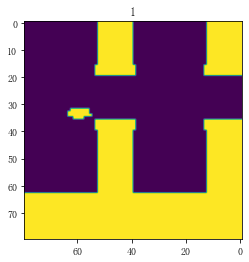

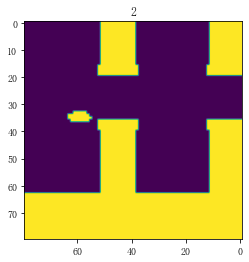

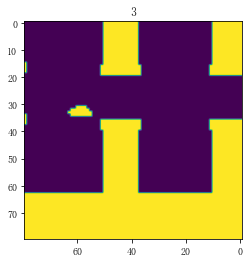

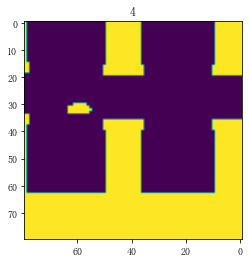

步数 245001 Q值 [12.110411 11.978513]===> 步数 245001 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 266 / 最高得分 1835
步数 245002 Q值 [12.369265 11.546101]===> 步数 245002 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 266 / 最高得分 1835
步数 245003 Q值 [12.443169 11.032236]===> 步数 245003 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 266 / 最高得分 1835
步数 245004 Q值 [12.422641  9.951013]===> 步数 245004 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 266 / 最高得分 1835
步数 245005 Q值 [12.42003   9.716106]===> 步数 245005 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 266 / 最高得分 1835
步数 245006 Q值 [12.485712  8.001022]===> 步数 245006 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 266 / 最高得分 1835
步数 245007 Q值 [12.54406   6.257318]===> 步数 245007 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 266 / 最高得分 1835
步数 245008 Q值 [12.550452  5.114572]===> 步数 245008 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 266 / 最高得分 1835
步数 245009 Q值 [12.607936   6.5206137]===> 步数 245009 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 266 / 最高得分 1835
步数 245010 Q值 [12.59465   6.481053]===> 步数 245010 / 本次

步数 245080 Q值 [12.532628  8.750535]===> 步数 245080 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 268 / 最高得分 1835
步数 245081 Q值 [12.487319   5.9484944]===> 步数 245081 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 268 / 最高得分 1835
步数 245082 Q值 [12.565846   4.7788963]===> 步数 245082 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 268 / 最高得分 1835
步数 245083 Q值 [12.574487   2.5977437]===> 步数 245083 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 268 / 最高得分 1835
步数 245084 Q值 [12.616124   3.2712562]===> 步数 245084 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 268 / 最高得分 1835
步数 245085 Q值 [12.624205  3.439014]===> 步数 245085 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 268 / 最高得分 1835
步数 245086 Q值 [12.610918   4.5728884]===> 步数 245086 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 268 / 最高得分 1835
步数 245087 Q值 [12.531565   4.8068566]===> 步数 245087 / 本次行为 0 不跳 / 本次奖励 1 / Running / 当前分数 269 / 最高得分 1835
步数 245088 Q值 [11.662436  3.043607]===> 步数 245088 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 269 / 最高得分 1835
步数 245089 Q值 [11.703672   5.1337633]===> 步数 2

步数 245162 Q值 [11.909259  2.887372]===> 步数 245162 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 271 / 最高得分 1835
步数 245163 Q值 [11.896601  3.173132]===> 步数 245163 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 271 / 最高得分 1835
步数 245164 Q值 [11.956937   4.2724037]===> 步数 245164 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 271 / 最高得分 1835
步数 245165 Q值 [11.95236   5.641557]===> 步数 245165 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 271 / 最高得分 1835
步数 245166 Q值 [11.922166   7.8610387]===> 步数 245166 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 271 / 最高得分 1835
步数 245167 Q值 [11.82834   9.641757]===> 步数 245167 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 271 / 最高得分 1835
步数 245168 Q值 [11.894699  9.911614]===> 步数 245168 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 271 / 最高得分 1835
步数 245169 Q值 [11.928189 10.22015 ]===> 步数 245169 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 271 / 最高得分 1835
步数 245170 Q值 [12.0377445 10.93285  ]===> 步数 245170 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 271 / 最高得分 1835
步数 245171 Q值 [12.039142 10.875701]===> 步数 245171 

步数 245244 Q值 [12.020974  9.615347]===> 步数 245244 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 273 / 最高得分 1835
步数 245245 Q值 [11.973018  9.713517]===> 步数 245245 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 273 / 最高得分 1835
步数 245246 Q值 [11.946361   5.4821386]===> 步数 245246 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 273 / 最高得分 1835
步数 245247 Q值 [11.942844   2.6008759]===> 步数 245247 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 273 / 最高得分 1835
步数 245248 Q值 [12.011837   1.3792963]===> 步数 245248 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 273 / 最高得分 1835
步数 245249 Q值 [12.046916   0.6577546]===> 步数 245249 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 273 / 最高得分 1835
步数 245250 Q值 [12.027431    0.21867658]===> 步数 245250 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 273 / 最高得分 1835
步数 245251 Q值 [12.014337   -0.46786818]===> 步数 245251 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 273 / 最高得分 1835
步数 245252 Q值 [12.099152   -0.45171794]===> 步数 245252 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 273 / 最高得分 1835
步数 245253 Q值 [12.236768   -0.720833

步数 245325 Q值 [12.169199  9.911934]===> 步数 245325 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 275 / 最高得分 1835
步数 245326 Q值 [12.1653805  9.761116 ]===> 步数 245326 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 275 / 最高得分 1835
步数 245327 Q值 [12.232828 10.429876]===> 步数 245327 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 275 / 最高得分 1835
步数 245328 Q值 [12.206845 10.969379]===> 步数 245328 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 275 / 最高得分 1835
步数 245329 Q值 [12.125026 11.883021]===> 步数 245329 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 275 / 最高得分 1835
步数 245330 Q值 [12.058442 11.914177]===> 步数 245330 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 275 / 最高得分 1835
步数 245331 Q值 [10.899915 12.121171]===> 步数 245331 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 275 / 最高得分 1835
步数 245332 Q值 [12.239073 11.838278]===> 步数 245332 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 275 / 最高得分 1835
步数 245333 Q值 [12.373086 11.30293 ]===> 步数 245333 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 275 / 最高得分 1835
步数 245334 Q值 [12.290378 11.869281]===> 步数 245334 / 本次行

步数 245403 Q值 [12.093784  4.488936]===> 步数 245403 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 277 / 最高得分 1835
步数 245404 Q值 [12.165647   6.4005976]===> 步数 245404 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 277 / 最高得分 1835
步数 245405 Q值 [12.245547  9.838902]===> 步数 245405 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 277 / 最高得分 1835
步数 245406 Q值 [11.9981365 11.605838 ]===> 步数 245406 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 277 / 最高得分 1835
步数 245407 Q值 [10.807085 12.80351 ]===> 步数 245407 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 277 / 最高得分 1835
步数 245408 Q值 [12.313091 11.895499]===> 步数 245408 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 277 / 最高得分 1835
步数 245409 Q值 [12.396833 11.121191]===> 步数 245409 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 277 / 最高得分 1835
步数 245410 Q值 [12.457443 10.656232]===> 步数 245410 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 277 / 最高得分 1835
步数 245411 Q值 [12.513448 10.284639]===> 步数 245411 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 277 / 最高得分 1835
步数 245412 Q值 [12.537821  8.194771]===> 步数 245412 / 本

步数 245481 Q值 [12.395502 11.56786 ]===> 步数 245481 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 279 / 最高得分 1835
步数 245482 Q值 [12.38681  11.947113]===> 步数 245482 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 279 / 最高得分 1835
步数 245483 Q值 [12.510635 11.798539]===> 步数 245483 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 279 / 最高得分 1835
步数 245484 Q值 [12.582681 11.260752]===> 步数 245484 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 279 / 最高得分 1835
步数 245485 Q值 [12.673266 10.64356 ]===> 步数 245485 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 279 / 最高得分 1835
步数 245486 Q值 [12.630638  8.969488]===> 步数 245486 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 279 / 最高得分 1835
步数 245487 Q值 [12.612988  7.729757]===> 步数 245487 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 279 / 最高得分 1835
步数 245488 Q值 [12.674986  6.291634]===> 步数 245488 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 279 / 最高得分 1835
步数 245489 Q值 [12.73141    6.2674036]===> 步数 245489 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 279 / 最高得分 1835
步数 245490 Q值 [12.67189    6.2223787]===> 步数 245490 / 

步数 245564 Q值 [12.480809  1.454217]===> 步数 245564 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 281 / 最高得分 1835
步数 245565 Q值 [12.378161   1.8531073]===> 步数 245565 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 281 / 最高得分 1835
步数 245566 Q值 [12.393348  3.296676]===> 步数 245566 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 281 / 最高得分 1835
步数 245567 Q值 [12.467816   2.0861793]===> 步数 245567 / 本次行为 0 不跳 / 本次奖励 1 / Running / 当前分数 282 / 最高得分 1835
步数 245568 Q值 [11.6983385  3.098232 ]===> 步数 245568 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 282 / 最高得分 1835
步数 245569 Q值 [11.654045  5.768941]===> 步数 245569 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 282 / 最高得分 1835
步数 245570 Q值 [11.733208  7.233847]===> 步数 245570 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 282 / 最高得分 1835
步数 245571 Q值 [11.719621  9.600014]===> 步数 245571 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 282 / 最高得分 1835
步数 245572 Q值 [11.772543 10.985383]===> 步数 245572 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 282 / 最高得分 1835
步数 245573 Q值 [11.723357 11.054118]===> 步数 245573 / 

步数 245645 Q值 [11.877211   7.1063237]===> 步数 245645 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 284 / 最高得分 1835
步数 245646 Q值 [11.90527   9.166721]===> 步数 245646 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 284 / 最高得分 1835
步数 245647 Q值 [11.864515 10.204524]===> 步数 245647 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 284 / 最高得分 1835
步数 245648 Q值 [11.866981 10.609111]===> 步数 245648 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 284 / 最高得分 1835
步数 245649 Q值 [11.90453 11.1089 ]===> 步数 245649 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 284 / 最高得分 1835
步数 245650 Q值 [11.875393 11.3043  ]===> 步数 245650 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 284 / 最高得分 1835
步数 245651 Q值 [11.845613 11.024273]===> 步数 245651 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 284 / 最高得分 1835
步数 245652 Q值 [11.863666 11.23898 ]===> 步数 245652 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 284 / 最高得分 1835
步数 245653 Q值 [11.843701 11.196087]===> 步数 245653 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 284 / 最高得分 1835
步数 245654 Q值 [11.829877 11.547184]===> 步数 245654 / 本次行为

步数 245723 Q值 [11.699074  12.1704235]===> 步数 245723 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 286 / 最高得分 1835
步数 245724 Q值 [11.984579 11.894104]===> 步数 245724 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 286 / 最高得分 1835
步数 245725 Q值 [11.893924  11.2402115]===> 步数 245725 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 286 / 最高得分 1835
步数 245726 Q值 [11.92317  11.088648]===> 步数 245726 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 286 / 最高得分 1835
步数 245727 Q值 [11.925471 10.66037 ]===> 步数 245727 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 286 / 最高得分 1835
步数 245728 Q值 [12.002157  9.134145]===> 步数 245728 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 286 / 最高得分 1835
步数 245729 Q值 [12.008149   7.2842984]===> 步数 245729 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 286 / 最高得分 1835
步数 245730 Q值 [12.069442   5.6126466]===> 步数 245730 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 286 / 最高得分 1835
步数 245731 Q值 [12.179358   3.7211025]===> 步数 245731 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 286 / 最高得分 1835
步数 245732 Q值 [12.162346   2.7605991]===> 步数 24

步数 245805 Q值 [12.070389  11.7210865]===> 步数 245805 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 288 / 最高得分 1835
步数 245806 Q值 [12.145623 11.690578]===> 步数 245806 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 288 / 最高得分 1835
步数 245807 Q值 [12.206766 11.67912 ]===> 步数 245807 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 288 / 最高得分 1835
步数 245808 Q值 [12.275196 11.894825]===> 步数 245808 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 288 / 最高得分 1835
步数 245809 Q值 [12.2766   11.785234]===> 步数 245809 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 288 / 最高得分 1835
步数 245810 Q值 [12.17336 11.57054]===> 步数 245810 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 288 / 最高得分 1835
步数 245811 Q值 [12.194983 11.33441 ]===> 步数 245811 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 288 / 最高得分 1835
步数 245812 Q值 [12.276222 11.430984]===> 步数 245812 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 288 / 最高得分 1835
步数 245813 Q值 [12.402424 11.917702]===> 步数 245813 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 288 / 最高得分 1835
步数 245814 Q值 [12.38032  11.904582]===> 步数 245814 / 本次行为

步数 245887 Q值 [12.063057  6.491106]===> 步数 245887 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 290 / 最高得分 1835
步数 245888 Q值 [12.112779  8.743814]===> 步数 245888 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 290 / 最高得分 1835
步数 245889 Q值 [12.0999365 11.750656 ]===> 步数 245889 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 290 / 最高得分 1835
步数 245890 Q值 [ 8.629066 12.27492 ]===> 步数 245890 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 290 / 最高得分 1835
步数 245891 Q值 [12.391472 11.739099]===> 步数 245891 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 290 / 最高得分 1835
步数 245892 Q值 [12.396907 11.22041 ]===> 步数 245892 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 290 / 最高得分 1835
步数 245893 Q值 [12.4697895 10.443142 ]===> 步数 245893 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 290 / 最高得分 1835
步数 245894 Q值 [12.455463  9.81837 ]===> 步数 245894 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 290 / 最高得分 1835
步数 245895 Q值 [12.491608   7.6433225]===> 步数 245895 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 290 / 最高得分 1835
步数 245896 Q值 [12.45594   6.799916]===> 步数 245896 /

步数 245970 Q值 [12.540976   3.2308166]===> 步数 245970 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 292 / 最高得分 1835
步数 245971 Q值 [12.478128   1.6995158]===> 步数 245971 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 292 / 最高得分 1835
步数 245972 Q值 [12.470875   1.9487611]===> 步数 245972 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 292 / 最高得分 1835
步数 245973 Q值 [12.615389   2.4098794]===> 步数 245973 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 292 / 最高得分 1835
步数 245974 Q值 [12.633174   2.3612568]===> 步数 245974 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 292 / 最高得分 1835
步数 245975 Q值 [12.604738   1.0070002]===> 步数 245975 / 本次行为 0 不跳 / 本次奖励 1 / Running / 当前分数 293 / 最高得分 1835
步数 245976 Q值 [11.743511  0.677183]===> 步数 245976 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 293 / 最高得分 1835
步数 245977 Q值 [11.693905   1.8464496]===> 步数 245977 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 293 / 最高得分 1835
步数 245978 Q值 [11.6913395  5.70693  ]===> 步数 245978 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 293 / 最高得分 1835
步数 245979 Q值 [11.691879  9.967334]===> 步数

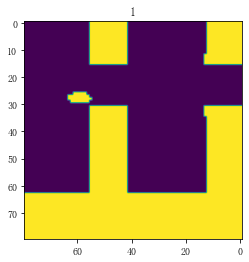

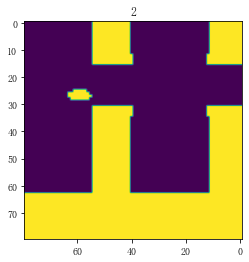

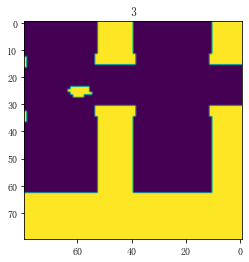

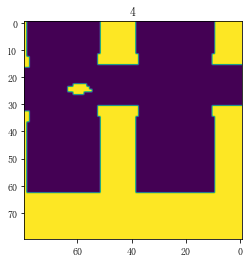

步数 246001 Q值 [10.28945 11.8655 ]===> 步数 246001 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 293 / 最高得分 1835
步数 246002 Q值 [12.412489 11.270202]===> 步数 246002 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 293 / 最高得分 1835
步数 246003 Q值 [12.16886   9.770819]===> 步数 246003 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 293 / 最高得分 1835
步数 246004 Q值 [12.424368   6.4601464]===> 步数 246004 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 293 / 最高得分 1835
步数 246005 Q值 [12.518136  5.004542]===> 步数 246005 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 293 / 最高得分 1835
步数 246006 Q值 [12.486275   2.9562962]===> 步数 246006 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 293 / 最高得分 1835
步数 246007 Q值 [12.403238  1.470279]===> 步数 246007 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 293 / 最高得分 1835
步数 246008 Q值 [12.504324   2.0536852]===> 步数 246008 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 293 / 最高得分 1835
步数 246009 Q值 [12.538813   1.9766531]===> 步数 246009 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 293 / 最高得分 1835
步数 246010 Q值 [12.64979    2.5436463]===> 步数 246010

步数 246084 Q值 [11.734499 11.776129]===> 步数 246084 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 0 / 最高得分 1835
步数 246085 Q值 [11.882344 11.406329]===> 步数 246085 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 0 / 最高得分 1835
步数 246086 Q值 [11.964005 11.54888 ]===> 步数 246086 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 0 / 最高得分 1835
步数 246087 Q值 [11.9361105 11.746762 ]===> 步数 246087 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 0 / 最高得分 1835
步数 246088 Q值 [11.856724 11.614737]===> 步数 246088 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 0 / 最高得分 1835
步数 246089 Q值 [11.753632 11.416728]===> 步数 246089 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 0 / 最高得分 1835
步数 246090 Q值 [11.761253 11.629908]===> 步数 246090 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 0 / 最高得分 1835
步数 246091 Q值 [11.802405 11.66649 ]===> 步数 246091 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 0 / 最高得分 1835
步数 246092 Q值 [11.821614 11.543995]===> 步数 246092 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 0 / 最高得分 1835
步数 246093 Q值 [11.8205   11.557172]===> 步数 246093 / 本次行为 0 不跳 / 本次奖励 0.1 

步数 246165 Q值 [12.507807  6.386956]===> 步数 246165 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 1 / 最高得分 1835
步数 246166 Q值 [12.480127  5.433256]===> 步数 246166 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 1 / 最高得分 1835
步数 246167 Q值 [12.462297   4.2570972]===> 步数 246167 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 1 / 最高得分 1835
步数 246168 Q值 [12.512887  4.28214 ]===> 步数 246168 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 1 / 最高得分 1835
步数 246169 Q值 [12.534172   4.2154865]===> 步数 246169 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 1 / 最高得分 1835
步数 246170 Q值 [12.752457  5.876983]===> 步数 246170 / 本次行为 0 不跳 / 本次奖励 1 / Running / 当前分数 2 / 最高得分 1835
步数 246171 Q值 [11.934169  6.052803]===> 步数 246171 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 2 / 最高得分 1835
步数 246172 Q值 [11.7737875  7.7547283]===> 步数 246172 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 2 / 最高得分 1835
步数 246173 Q值 [11.713059  8.103778]===> 步数 246173 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 2 / 最高得分 1835
步数 246174 Q值 [11.853205 10.240522]===> 步数 246174 / 本次行为 0 不跳 / 本次奖励 0

步数 246246 Q值 [11.686973  5.608156]===> 步数 246246 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 4 / 最高得分 1835
步数 246247 Q值 [11.773676  9.643264]===> 步数 246247 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 4 / 最高得分 1835
步数 246248 Q值 [11.882057 10.87459 ]===> 步数 246248 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 4 / 最高得分 1835
步数 246249 Q值 [11.920366 11.162422]===> 步数 246249 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 4 / 最高得分 1835
步数 246250 Q值 [11.882162 11.504337]===> 步数 246250 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 4 / 最高得分 1835
步数 246251 Q值 [11.681659 11.85432 ]===> 步数 246251 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 4 / 最高得分 1835
步数 246252 Q值 [11.95098  11.354219]===> 步数 246252 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 4 / 最高得分 1835
步数 246253 Q值 [11.856338 10.810566]===> 步数 246253 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 4 / 最高得分 1835
步数 246254 Q值 [11.830917 10.097682]===> 步数 246254 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 4 / 最高得分 1835
步数 246255 Q值 [11.928833  8.605873]===> 步数 246255 / 本次行为 0 不跳 / 本次奖励 0.1 / 

步数 246328 Q值 [11.964151 10.546959]===> 步数 246328 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 6 / 最高得分 1835
步数 246329 Q值 [11.949246 11.070863]===> 步数 246329 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 6 / 最高得分 1835
步数 246330 Q值 [12.125447 11.362785]===> 步数 246330 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 6 / 最高得分 1835
步数 246331 Q值 [11.882342 10.581688]===> 步数 246331 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 6 / 最高得分 1835
步数 246332 Q值 [12.03111  11.061308]===> 步数 246332 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 6 / 最高得分 1835
步数 246333 Q值 [12.007074 11.780425]===> 步数 246333 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 6 / 最高得分 1835
步数 246334 Q值 [12.082776  12.0259285]===> 步数 246334 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 6 / 最高得分 1835
步数 246335 Q值 [11.996721 12.154219]===> 步数 246335 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 6 / 最高得分 1835
步数 246336 Q值 [12.165774 11.347883]===> 步数 246336 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 6 / 最高得分 1835
步数 246337 Q值 [12.205296 11.074284]===> 步数 246337 / 本次行为 0 不跳 / 本次奖励 0.1 

步数 246407 Q值 [12.032127  6.033632]===> 步数 246407 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 8 / 最高得分 1835
步数 246408 Q值 [12.187293  7.546064]===> 步数 246408 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 8 / 最高得分 1835
步数 246409 Q值 [12.137054  8.369627]===> 步数 246409 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 8 / 最高得分 1835
步数 246410 Q值 [12.146442  8.366195]===> 步数 246410 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 8 / 最高得分 1835
步数 246411 Q值 [12.363229  9.943903]===> 步数 246411 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 8 / 最高得分 1835
步数 246412 Q值 [12.330488 11.405827]===> 步数 246412 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 8 / 最高得分 1835
步数 246413 Q值 [12.340803 12.04155 ]===> 步数 246413 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 8 / 最高得分 1835
步数 246414 Q值 [11.78756  12.670154]===> 步数 246414 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 8 / 最高得分 1835
步数 246415 Q值 [12.382747 12.135584]===> 步数 246415 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 8 / 最高得分 1835
步数 246416 Q值 [12.385268 11.621997]===> 步数 246416 / 本次行为 0 不跳 / 本次奖励 0.1 / 

步数 246491 Q值 [12.337825 11.635114]===> 步数 246491 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 10 / 最高得分 1835
步数 246492 Q值 [12.321532 11.596582]===> 步数 246492 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 10 / 最高得分 1835
步数 246493 Q值 [12.286273 11.687772]===> 步数 246493 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 10 / 最高得分 1835
步数 246494 Q值 [12.327839 11.81671 ]===> 步数 246494 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 10 / 最高得分 1835
步数 246495 Q值 [12.318481 11.478229]===> 步数 246495 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 10 / 最高得分 1835
步数 246496 Q值 [12.366918 11.428904]===> 步数 246496 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 10 / 最高得分 1835
步数 246497 Q值 [12.417916 11.996704]===> 步数 246497 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 10 / 最高得分 1835
步数 246498 Q值 [12.418292 12.529482]===> 步数 246498 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 10 / 最高得分 1835
步数 246499 Q值 [12.530101 11.354517]===> 步数 246499 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 10 / 最高得分 1835
步数 246500 Q值 [12.568406  9.819758]===> 步数 246500 / 本次行为 0 不跳 / 本次

步数 246573 Q值 [12.539708  8.553908]===> 步数 246573 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 12 / 最高得分 1835
步数 246574 Q值 [12.532818  9.195699]===> 步数 246574 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 12 / 最高得分 1835
步数 246575 Q值 [12.544931 10.004868]===> 步数 246575 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 12 / 最高得分 1835
步数 246576 Q值 [12.548367 10.508784]===> 步数 246576 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 12 / 最高得分 1835
步数 246577 Q值 [12.607684 11.657154]===> 步数 246577 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 12 / 最高得分 1835
步数 246578 Q值 [12.58396  11.781878]===> 步数 246578 / 本次行为 0 不跳 / 本次奖励 1 / Running / 当前分数 13 / 最高得分 1835
步数 246579 Q值 [10.679982 11.66067 ]===> 步数 246579 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 13 / 最高得分 1835
步数 246580 Q值 [11.726968 11.16681 ]===> 步数 246580 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 13 / 最高得分 1835
步数 246581 Q值 [11.742372 10.428606]===> 步数 246581 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 13 / 最高得分 1835
步数 246582 Q值 [11.820186 10.511914]===> 步数 246582 / 本次行为 0 不跳 / 本次奖励

步数 246654 Q值 [11.758567 10.52904 ]===> 步数 246654 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 15 / 最高得分 1835
步数 246655 Q值 [11.756315 11.737272]===> 步数 246655 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 15 / 最高得分 1835
步数 246656 Q值 [11.459196 11.825081]===> 步数 246656 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 15 / 最高得分 1835
步数 246657 Q值 [11.778205 11.495429]===> 步数 246657 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 15 / 最高得分 1835
步数 246658 Q值 [11.825173 11.064983]===> 步数 246658 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 15 / 最高得分 1835
步数 246659 Q值 [11.874398 11.247518]===> 步数 246659 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 15 / 最高得分 1835
步数 246660 Q值 [11.878692 10.909606]===> 步数 246660 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 15 / 最高得分 1835
步数 246661 Q值 [11.937513 10.77684 ]===> 步数 246661 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 15 / 最高得分 1835
步数 246662 Q值 [11.966198 10.750661]===> 步数 246662 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 15 / 最高得分 1835
步数 246663 Q值 [11.948741  10.5716915]===> 步数 246663 / 本次行为 0 不跳 / 

步数 246737 Q值 [11.956306   7.8828387]===> 步数 246737 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 17 / 最高得分 1835
步数 246738 Q值 [12.10071    4.9524183]===> 步数 246738 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 17 / 最高得分 1835
步数 246739 Q值 [12.16414   3.475576]===> 步数 246739 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 17 / 最高得分 1835
步数 246740 Q值 [12.174567   3.5242732]===> 步数 246740 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 17 / 最高得分 1835
步数 246741 Q值 [12.096079   3.1409402]===> 步数 246741 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 17 / 最高得分 1835
步数 246742 Q值 [12.089689   2.3207932]===> 步数 246742 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 17 / 最高得分 1835
步数 246743 Q值 [12.118699   2.4756525]===> 步数 246743 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 17 / 最高得分 1835
步数 246744 Q值 [12.186932   1.7024319]===> 步数 246744 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 17 / 最高得分 1835
步数 246745 Q值 [12.165687    0.94545704]===> 步数 246745 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 17 / 最高得分 1835
步数 246746 Q值 [12.117361   -0.16296601]===> 步数 

步数 246820 Q值 [12.258863   1.0739218]===> 步数 246820 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 19 / 最高得分 1835
步数 246821 Q值 [12.101784    0.45740938]===> 步数 246821 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 19 / 最高得分 1835
步数 246822 Q值 [12.146475   0.4793759]===> 步数 246822 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 19 / 最高得分 1835
步数 246823 Q值 [12.058438    0.16095361]===> 步数 246823 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 19 / 最高得分 1835
步数 246824 Q值 [12.228853   1.8407243]===> 步数 246824 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 19 / 最高得分 1835
步数 246825 Q值 [12.300228   4.2676506]===> 步数 246825 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 19 / 最高得分 1835
步数 246826 Q值 [12.368809   7.6906157]===> 步数 246826 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 19 / 最高得分 1835
步数 246827 Q值 [12.441987 10.765565]===> 步数 246827 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 19 / 最高得分 1835
步数 246828 Q值 [11.282192 12.246904]===> 步数 246828 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 19 / 最高得分 1835
步数 246829 Q值 [12.429499 11.095177]===> 步数 24682

步数 246903 Q值 [12.575774  6.947838]===> 步数 246903 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 21 / 最高得分 1835
步数 246904 Q值 [12.573953  4.450736]===> 步数 246904 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 21 / 最高得分 1835
步数 246905 Q值 [12.686232  5.991475]===> 步数 246905 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 21 / 最高得分 1835
步数 246906 Q值 [12.633067  6.295727]===> 步数 246906 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 21 / 最高得分 1835
步数 246907 Q值 [12.5488825  5.9254003]===> 步数 246907 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 21 / 最高得分 1835
步数 246908 Q值 [12.594683  7.465439]===> 步数 246908 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 21 / 最高得分 1835
步数 246909 Q值 [12.568796  9.340374]===> 步数 246909 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 21 / 最高得分 1835
步数 246910 Q值 [12.619188 10.599402]===> 步数 246910 / 本次行为 0 不跳 / 本次奖励 1 / Running / 当前分数 22 / 最高得分 1835
步数 246911 Q值 [11.73179  10.523623]===> 步数 246911 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 22 / 最高得分 1835
步数 246912 Q值 [11.712172 11.239647]===> 步数 246912 / 本次行为 0 不跳 / 本

步数 246985 Q值 [11.734453 10.120115]===> 步数 246985 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 24 / 最高得分 1835
步数 246986 Q值 [11.710016 10.008472]===> 步数 246986 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 24 / 最高得分 1835
步数 246987 Q值 [11.7429    9.223943]===> 步数 246987 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 24 / 最高得分 1835
步数 246988 Q值 [11.854343 10.066123]===> 步数 246988 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 24 / 最高得分 1835
步数 246989 Q值 [11.861328  8.96466 ]===> 步数 246989 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 24 / 最高得分 1835
步数 246990 Q值 [11.835337   6.8133903]===> 步数 246990 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 24 / 最高得分 1835
步数 246991 Q值 [11.756159  6.894089]===> 步数 246991 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 24 / 最高得分 1835
步数 246992 Q值 [11.746699   5.5479217]===> 步数 246992 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 24 / 最高得分 1835
步数 246993 Q值 [11.766126  4.96587 ]===> 步数 246993 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 24 / 最高得分 1835
步数 246994 Q值 [11.775174  4.651459]===> 步数 246994 / 本次行为 0 不跳

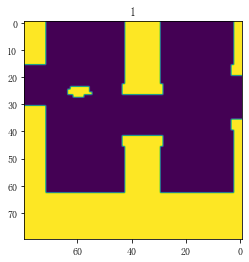

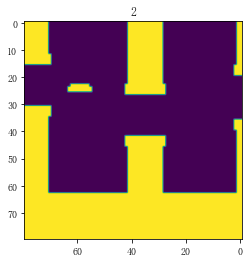

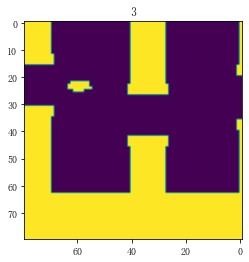

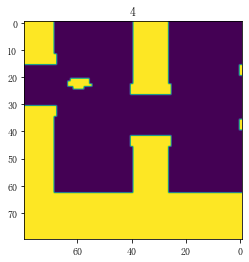

步数 247001 Q值 [12.102145    0.55690557]===> 步数 247001 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 24 / 最高得分 1835
步数 247002 Q值 [12.118429  -0.1167907]===> 步数 247002 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 24 / 最高得分 1835
步数 247003 Q值 [12.201062    0.69685894]===> 步数 247003 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 24 / 最高得分 1835
步数 247004 Q值 [12.211482  2.076372]===> 步数 247004 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 24 / 最高得分 1835
步数 247005 Q值 [12.149603   3.8800447]===> 步数 247005 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 24 / 最高得分 1835
步数 247006 Q值 [12.243163  6.08083 ]===> 步数 247006 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 24 / 最高得分 1835
步数 247007 Q值 [12.243682  9.175099]===> 步数 247007 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 24 / 最高得分 1835
步数 247008 Q值 [12.245061 10.638469]===> 步数 247008 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 24 / 最高得分 1835
步数 247009 Q值 [12.364046 11.736703]===> 步数 247009 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 24 / 最高得分 1835
步数 247010 Q值 [11.979884 12.272413]===> 步数 247010 / 本

步数 247084 Q值 [12.074367 11.985461]===> 步数 247084 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 26 / 最高得分 1835
步数 247085 Q值 [ 7.570968 12.25919 ]===> 步数 247085 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 26 / 最高得分 1835
步数 247086 Q值 [12.172667 10.983701]===> 步数 247086 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 26 / 最高得分 1835
步数 247087 Q值 [12.365062 10.887025]===> 步数 247087 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 26 / 最高得分 1835
步数 247088 Q值 [12.488629 11.271796]===> 步数 247088 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 26 / 最高得分 1835
步数 247089 Q值 [12.551942 10.568335]===> 步数 247089 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 26 / 最高得分 1835
步数 247090 Q值 [12.646061  8.406982]===> 步数 247090 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 26 / 最高得分 1835
步数 247091 Q值 [12.6770525  8.334016 ]===> 步数 247091 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 26 / 最高得分 1835
步数 247092 Q值 [12.710775  8.322308]===> 步数 247092 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 26 / 最高得分 1835
步数 247093 Q值 [12.822715  6.361789]===> 步数 247093 / 本次行为 0 不跳 / 

步数 247166 Q值 [12.487403   6.0765653]===> 步数 247166 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 28 / 最高得分 1835
步数 247167 Q值 [12.547987   6.0584335]===> 步数 247167 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 28 / 最高得分 1835
步数 247168 Q值 [12.63452    6.5456157]===> 步数 247168 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 28 / 最高得分 1835
步数 247169 Q值 [12.649255  9.232226]===> 步数 247169 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 28 / 最高得分 1835
步数 247170 Q值 [12.636941 10.650496]===> 步数 247170 / 本次行为 0 不跳 / 本次奖励 1 / Running / 当前分数 29 / 最高得分 1835
步数 247171 Q值 [11.782842 10.517738]===> 步数 247171 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 29 / 最高得分 1835
步数 247172 Q值 [11.731539 11.634948]===> 步数 247172 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 29 / 最高得分 1835
步数 247173 Q值 [ 8.646281 11.7625  ]===> 步数 247173 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 29 / 最高得分 1835
步数 247174 Q值 [11.940018 11.532776]===> 步数 247174 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 29 / 最高得分 1835
步数 247175 Q值 [11.944164 11.078942]===> 步数 247175 / 本次行为 0 不跳 

步数 247249 Q值 [11.665376 10.72631 ]===> 步数 247249 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 31 / 最高得分 1835
步数 247250 Q值 [11.663776 10.444768]===> 步数 247250 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 31 / 最高得分 1835
步数 247251 Q值 [11.698001 10.334763]===> 步数 247251 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 31 / 最高得分 1835
步数 247252 Q值 [11.709596  9.480883]===> 步数 247252 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 31 / 最高得分 1835
步数 247253 Q值 [11.839269   7.7244186]===> 步数 247253 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 31 / 最高得分 1835
步数 247254 Q值 [11.905389   7.3392863]===> 步数 247254 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 31 / 最高得分 1835
步数 247255 Q值 [11.897586  7.788939]===> 步数 247255 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 31 / 最高得分 1835
步数 247256 Q值 [11.94389    7.0228643]===> 步数 247256 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 31 / 最高得分 1835
步数 247257 Q值 [12.039022  6.57965 ]===> 步数 247257 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 31 / 最高得分 1835
步数 247258 Q值 [12.031409  7.433345]===> 步数 247258 / 本次行为 0 

步数 247332 Q值 [11.98163  11.803612]===> 步数 247332 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 33 / 最高得分 1835
步数 247333 Q值 [12.087604 11.80095 ]===> 步数 247333 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 33 / 最高得分 1835
步数 247334 Q值 [12.116148 11.821418]===> 步数 247334 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 33 / 最高得分 1835
步数 247335 Q值 [12.218178 12.001388]===> 步数 247335 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 33 / 最高得分 1835
步数 247336 Q值 [12.100763 11.843159]===> 步数 247336 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 33 / 最高得分 1835
步数 247337 Q值 [12.147989 11.900127]===> 步数 247337 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 33 / 最高得分 1835
步数 247338 Q值 [12.145115 12.386599]===> 步数 247338 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 33 / 最高得分 1835
步数 247339 Q值 [12.236269 12.44617 ]===> 步数 247339 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 33 / 最高得分 1835
步数 247340 Q值 [12.28597  12.226674]===> 步数 247340 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 33 / 最高得分 1835
步数 247341 Q值 [12.15633 12.10814]===> 步数 247341 / 本次行为 0 不跳 / 本次奖励 

步数 247412 Q值 [12.075599   8.7399435]===> 步数 247412 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 35 / 最高得分 1835
步数 247413 Q值 [12.140023 10.574014]===> 步数 247413 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 35 / 最高得分 1835
步数 247414 Q值 [12.257936 11.44322 ]===> 步数 247414 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 35 / 最高得分 1835
步数 247415 Q值 [12.127501 12.002803]===> 步数 247415 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 35 / 最高得分 1835
步数 247416 Q值 [ 9.880615  12.4473915]===> 步数 247416 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 35 / 最高得分 1835
步数 247417 Q值 [12.04395  12.090625]===> 步数 247417 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 35 / 最高得分 1835
步数 247418 Q值 [12.506652 11.387229]===> 步数 247418 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 35 / 最高得分 1835
步数 247419 Q值 [12.42959  10.551934]===> 步数 247419 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 35 / 最高得分 1835
步数 247420 Q值 [12.430274  9.070894]===> 步数 247420 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 35 / 最高得分 1835
步数 247421 Q值 [12.578183  8.523992]===> 步数 247421 / 本次行为 0 不跳 /

步数 247494 Q值 [12.482698 10.446025]===> 步数 247494 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 37 / 最高得分 1835
步数 247495 Q值 [12.550622  9.545341]===> 步数 247495 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 37 / 最高得分 1835
步数 247496 Q值 [12.613669  8.670132]===> 步数 247496 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 37 / 最高得分 1835
步数 247497 Q值 [12.593484   7.6532273]===> 步数 247497 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 37 / 最高得分 1835
步数 247498 Q值 [12.471691   7.9008136]===> 步数 247498 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 37 / 最高得分 1835
步数 247499 Q值 [12.548285  7.449627]===> 步数 247499 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 37 / 最高得分 1835
步数 247500 Q值 [12.597858  8.400871]===> 步数 247500 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 37 / 最高得分 1835
步数 247501 Q值 [12.588715  9.161492]===> 步数 247501 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 37 / 最高得分 1835
步数 247502 Q值 [12.610088 10.430111]===> 步数 247502 / 本次行为 0 不跳 / 本次奖励 1 / Running / 当前分数 38 / 最高得分 1835
步数 247503 Q值 [11.79079  10.410723]===> 步数 247503 / 本次行为 0 不跳 /

步数 247575 Q值 [12.525383 10.598476]===> 步数 247575 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 39 / 最高得分 1835
步数 247576 Q值 [12.520569 11.162604]===> 步数 247576 / 本次行为 0 不跳 / 本次奖励 1 / Running / 当前分数 40 / 最高得分 1835
步数 247577 Q值 [11.798868 11.040237]===> 步数 247577 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 40 / 最高得分 1835
步数 247578 Q值 [11.6022005 11.505834 ]===> 步数 247578 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 40 / 最高得分 1835
步数 247579 Q值 [ 9.226272 11.769329]===> 步数 247579 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 40 / 最高得分 1835
步数 247580 Q值 [11.79485  11.578577]===> 步数 247580 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 40 / 最高得分 1835
步数 247581 Q值 [11.839522 11.214664]===> 步数 247581 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 40 / 最高得分 1835
步数 247582 Q值 [11.858005 11.243956]===> 步数 247582 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 40 / 最高得分 1835
步数 247583 Q值 [11.886721 11.20523 ]===> 步数 247583 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 40 / 最高得分 1835
步数 247584 Q值 [11.88687  10.599998]===> 步数 247584 / 本次行为 0 不跳 / 本次

步数 247653 Q值 [11.813326 11.823726]===> 步数 247653 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 42 / 最高得分 1835
步数 247654 Q值 [11.880956 11.185783]===> 步数 247654 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 42 / 最高得分 1835
步数 247655 Q值 [11.852713 10.430917]===> 步数 247655 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 42 / 最高得分 1835
步数 247656 Q值 [11.870766 10.386761]===> 步数 247656 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 42 / 最高得分 1835
步数 247657 Q值 [11.932994 10.142131]===> 步数 247657 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 42 / 最高得分 1835
步数 247658 Q值 [11.930602  8.297817]===> 步数 247658 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 42 / 最高得分 1835
步数 247659 Q值 [11.946499  7.104202]===> 步数 247659 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 42 / 最高得分 1835
步数 247660 Q值 [11.925008  6.234942]===> 步数 247660 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 42 / 最高得分 1835
步数 247661 Q值 [11.900664  5.628931]===> 步数 247661 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 42 / 最高得分 1835
步数 247662 Q值 [11.920057   4.4316754]===> 步数 247662 / 本次行为 0 不跳 / 

步数 247731 Q值 [11.841974 11.318703]===> 步数 247731 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 44 / 最高得分 1835
步数 247732 Q值 [11.823795 11.917208]===> 步数 247732 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 44 / 最高得分 1835
步数 247733 Q值 [11.849301 11.689461]===> 步数 247733 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 44 / 最高得分 1835
步数 247734 Q值 [11.888286 11.084303]===> 步数 247734 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 44 / 最高得分 1835
步数 247735 Q值 [11.892386 10.820869]===> 步数 247735 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 44 / 最高得分 1835
步数 247736 Q值 [11.92448  10.549405]===> 步数 247736 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 44 / 最高得分 1835
步数 247737 Q值 [11.944006  9.480949]===> 步数 247737 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 44 / 最高得分 1835
步数 247738 Q值 [11.960467  8.743403]===> 步数 247738 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 44 / 最高得分 1835
步数 247739 Q值 [11.971388   7.9205017]===> 步数 247739 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 44 / 最高得分 1835
步数 247740 Q值 [11.995471   6.2215104]===> 步数 247740 / 本次行为 0 不跳 

步数 247815 Q值 [11.90808  11.734502]===> 步数 247815 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 46 / 最高得分 1835
步数 247816 Q值 [11.951011 11.822826]===> 步数 247816 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 46 / 最高得分 1835
步数 247817 Q值 [12.176526 11.877603]===> 步数 247817 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 46 / 最高得分 1835
步数 247818 Q值 [12.216654 11.803242]===> 步数 247818 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 46 / 最高得分 1835
步数 247819 Q值 [12.095722 12.044844]===> 步数 247819 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 46 / 最高得分 1835
步数 247820 Q值 [12.182921 11.931194]===> 步数 247820 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 46 / 最高得分 1835
步数 247821 Q值 [11.551669 11.976831]===> 步数 247821 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 46 / 最高得分 1835
步数 247822 Q值 [12.189625 11.731141]===> 步数 247822 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 46 / 最高得分 1835
步数 247823 Q值 [12.330347 11.974157]===> 步数 247823 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 46 / 最高得分 1835
步数 247824 Q值 [12.374956 11.937939]===> 步数 247824 / 本次行为 0 不跳 / 本次

步数 247895 Q值 [12.110367   5.4804034]===> 步数 247895 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 48 / 最高得分 1835
步数 247896 Q值 [12.123355  8.208523]===> 步数 247896 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 48 / 最高得分 1835
步数 247897 Q值 [12.168691 10.164475]===> 步数 247897 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 48 / 最高得分 1835
步数 247898 Q值 [12.285465 11.168123]===> 步数 247898 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 48 / 最高得分 1835
步数 247899 Q值 [11.775211  12.2350025]===> 步数 247899 / 本次行为 1 跳 / 本次奖励 0.1 / Running / 当前分数 48 / 最高得分 1835
步数 247900 Q值 [12.313775 10.686081]===> 步数 247900 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 48 / 最高得分 1835
步数 247901 Q值 [12.270649  9.93047 ]===> 步数 247901 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 48 / 最高得分 1835
步数 247902 Q值 [12.426387  8.769637]===> 步数 247902 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 48 / 最高得分 1835
步数 247903 Q值 [12.433497   5.8385887]===> 步数 247903 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 48 / 最高得分 1835
步数 247904 Q值 [12.4850855  5.3919444]===> 步数 247904 / 本次行为 0

步数 247978 Q值 [12.514552  4.584058]===> 步数 247978 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 50 / 最高得分 1835
步数 247979 Q值 [12.544923   4.8351407]===> 步数 247979 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 50 / 最高得分 1835
步数 247980 Q值 [12.497857   2.8433683]===> 步数 247980 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 50 / 最高得分 1835
步数 247981 Q值 [12.54776   2.207161]===> 步数 247981 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 50 / 最高得分 1835
步数 247982 Q值 [12.592043  4.447151]===> 步数 247982 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 50 / 最高得分 1835
步数 247983 Q值 [12.565262   4.6003733]===> 步数 247983 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 50 / 最高得分 1835
步数 247984 Q值 [12.600821   5.4280124]===> 步数 247984 / 本次行为 0 不跳 / 本次奖励 1 / Running / 当前分数 51 / 最高得分 1835
步数 247985 Q值 [11.770233   7.2237587]===> 步数 247985 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 51 / 最高得分 1835
步数 247986 Q值 [11.865953 10.185418]===> 步数 247986 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 51 / 最高得分 1835
步数 247987 Q值 [11.881073 10.43414 ]===> 步数 247987 / 本次行为 

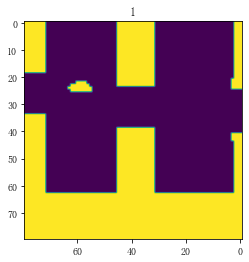

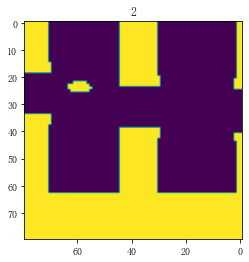

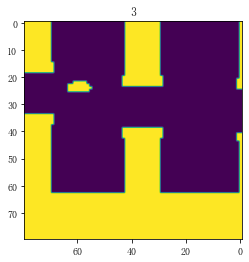

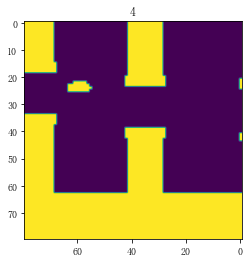

步数 248001 Q值 [12.18456    0.6750322]===> 步数 248001 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 51 / 最高得分 1835
步数 248002 Q值 [12.201284    0.45637763]===> 步数 248002 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 51 / 最高得分 1835
步数 248003 Q值 [12.25699   0.502268]===> 步数 248003 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 51 / 最高得分 1835
步数 248004 Q值 [12.276249   0.1338426]===> 步数 248004 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 51 / 最高得分 1835
步数 248005 Q值 [12.253867   0.4402987]===> 步数 248005 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 51 / 最高得分 1835
步数 248006 Q值 [12.203235   1.4444816]===> 步数 248006 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 51 / 最高得分 1835
步数 248007 Q值 [12.177044   3.9061918]===> 步数 248007 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 51 / 最高得分 1835
步数 248008 Q值 [12.22844    7.3798356]===> 步数 248008 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 51 / 最高得分 1835
步数 248009 Q值 [12.183171  8.975386]===> 步数 248009 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 51 / 最高得分 1835
步数 248010 Q值 [12.386297 11.40356 ]===> 步数 248010

步数 248085 Q值 [12.387227  8.715133]===> 步数 248085 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 53 / 最高得分 1835
步数 248086 Q值 [12.432198   6.8687363]===> 步数 248086 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 53 / 最高得分 1835
步数 248087 Q值 [12.498123  5.32897 ]===> 步数 248087 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 53 / 最高得分 1835
步数 248088 Q值 [12.455557  4.756562]===> 步数 248088 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 53 / 最高得分 1835
步数 248089 Q值 [12.378937   2.2521796]===> 步数 248089 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 53 / 最高得分 1835
步数 248090 Q值 [12.381882   2.4351559]===> 步数 248090 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 53 / 最高得分 1835
步数 248091 Q值 [12.322617  0.607153]===> 步数 248091 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 53 / 最高得分 1835
步数 248092 Q值 [12.3517885  0.5792957]===> 步数 248092 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 53 / 最高得分 1835
步数 248093 Q值 [12.490744   2.0277884]===> 步数 248093 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 53 / 最高得分 1835
步数 248094 Q值 [12.52672    3.9432669]===> 步数 248094 / 本

步数 248165 Q值 [12.730739   5.1593885]===> 步数 248165 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 55 / 最高得分 1835
步数 248166 Q值 [12.71665    2.4188936]===> 步数 248166 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 55 / 最高得分 1835
步数 248167 Q值 [12.758825   1.7195343]===> 步数 248167 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 55 / 最高得分 1835
步数 248168 Q值 [12.719736   2.2040236]===> 步数 248168 / 本次行为 0 不跳 / 本次奖励 1 / Running / 当前分数 56 / 最高得分 1835
步数 248169 Q值 [11.845644    0.21663389]===> 步数 248169 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 56 / 最高得分 1835
步数 248170 Q值 [11.885757   0.6608451]===> 步数 248170 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 56 / 最高得分 1835
步数 248171 Q值 [11.99853    2.0463607]===> 步数 248171 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 56 / 最高得分 1835
步数 248172 Q值 [12.013833  3.585361]===> 步数 248172 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 56 / 最高得分 1835
步数 248173 Q值 [11.962202   5.6821733]===> 步数 248173 / 本次行为 0 不跳 / 本次奖励 0.1 / Running / 当前分数 56 / 最高得分 1835
步数 248174 Q值 [11.859717  8.100204]===> 步数 248174

In [ ]:
import wrapped_flappy_bird as game

flappyBird = game.GameState()

timeStep = 0 
total_reward = 0
highest_record = 0

# 载入模型
model = load_model()

# 第一次与智能体交互
action = np.array([1, 0])# do nothing
observation0, reward, terminal = flappyBird.frame_step(action)

# 展示第一张图片
plt.imshow(np.rot90(np.rot90(np.rot90(observation0))))
plt.gca().invert_xaxis()
plt.title('The First Picture')
plt.show()

# 处理第一张图片
observation0 = cv2.cvtColor(cv2.resize(observation0, (80, 80)), cv2.COLOR_BGR2GRAY)
ret, observation0 = cv2.threshold(observation0, 1, 255, cv2.THRESH_BINARY)

# 展示第一张图片
plt.imshow(np.rot90(np.rot90(np.rot90(observation0))))
plt.gca().invert_xaxis()
plt.title('The First Picture')
plt.show()

# 第一次的4张图片都是一样的
currentObservation = np.stack((observation0, observation0, observation0, observation0), axis = 2)

while True:
    # 根据上一次的Observation，获得下一次的Action
    action, action_index = getAction(model, currentObservation, timeStep)
    
    # 将Action传入游戏，获得游戏的反馈(状态，奖励，是否GameOver，生效的行为)
    nextObservation, reward, terminal = flappyBird.frame_step(action)

    # 处理图片
    nextObservation = preprocess(nextObservation)
    
    # 将最近的图片后面追加老的前3张图片，从而得到一个新状态
    newObservation = np.append(nextObservation, currentObservation[:,:,:3], axis = 2)
        
    # 计算得分
    if terminal:
        total_reward = 0# Game Over 得分清零
    elif reward == 1:
        total_reward += reward
        
    if highest_record < total_reward:
        highest_record = total_reward

    # 更替状态
    currentObservation = newObservation
    
    # 打印日志
    if timeStep % 1 == 0:
        print_info(timeStep, action_index, reward, terminal, total_reward, highest_record)
        
    # 每第1000次，打印一次图片
    if timeStep % 1000 == 0:
        plt.imshow(np.rot90(np.rot90(np.rot90(currentObservation[:,:,0]))))
        plt.gca().invert_xaxis()
        plt.title('1')
        plt.show()
        
        plt.imshow(np.rot90(np.rot90(np.rot90(currentObservation[:,:,1]))))
        plt.gca().invert_xaxis()
        plt.title('2')
        plt.show()
        
        plt.imshow(np.rot90(np.rot90(np.rot90(currentObservation[:,:,2]))))
        plt.gca().invert_xaxis()
        plt.title('3')
        plt.show()
        
        plt.imshow(np.rot90(np.rot90(np.rot90(currentObservation[:,:,3]))))
        plt.gca().invert_xaxis()
        plt.title('4')
        plt.show()
        
    if timeStep % 10000 == 0:
        clear_output()
        
    timeStep += 1
